In [ ]:
import numpy as np
from torch.utils.data import DataLoader, TensorDataset

In [35]:
WINDOW_SIZE = 4000
NUM_CHANNELS = 16
X_pre = np.load("preictal_gan_train.npy")
X_pre = X_pre.reshape(-1, WINDOW_SIZE, NUM_CHANNELS)
y_pre = np.ones((X_pre.shape[0],))

In [36]:
X_pre.shape

(9499, 4000, 16)

In [37]:
X_pre_normalized = (X_pre - X_pre.min()) / (X_pre.max() - X_pre.min())

In [38]:
from sklearn.model_selection import train_test_split
X_pre_train, X_pre_val, y_pre_train, y_pre_val = train_test_split(X_pre_normalized, y_pre, test_size = 0.1, random_state=9)

In [39]:
import torch
import torch.nn as nn
import torch.optim as optim

# Define the Denoising Diffusion Probabilistic Model (DDPM)
class DDPM(nn.Module):
    def __init__(self, input_channels, num_filters):
        super(DDPM, self).__init__()
        
        # Encoder layers
        self.encoder = nn.Sequential(
            nn.Conv1d(input_channels, num_filters, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv1d(num_filters, num_filters, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
        )
        
        # Decoder layers
        self.decoder = nn.Sequential(
            nn.Conv1d(num_filters, num_filters, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv1d(num_filters, input_channels, kernel_size=3, stride=1, padding=1),
            nn.Sigmoid()  # Output range between 0 and 1
        )
        
    def forward(self, x):
        #encoded = self.encoder(x)
        encoded = self.encoder(x.permute(0, 2, 1))  # Permute to match Conv1d input format
        decoded = self.decoder(encoded)
        #return decoded
        return decoded.permute(0, 2, 1)  # Permute back to original shape

In [40]:
# Convert training data to PyTorch tensors
X_train_tensor = torch.tensor(X_pre_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_pre_train, dtype=torch.float32)

# Convert validation data to PyTorch tensors
X_val_tensor = torch.tensor(X_pre_val, dtype=torch.float32)
y_val_tensor = torch.tensor(y_pre_val, dtype=torch.float32)

# Create DataLoader for training set
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# Create DataLoader for validation set
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)  # No need to shuffle validation data

In [41]:
import numpy as np
from torch.utils.data import DataLoader, TensorDataset

# Hyperparameters
input_channels = 16  # NUM_CHANNELS
num_filters = 32
batch_size = 8  # Reducing batch size for demonstration purposes
learning_rate = 0.001
num_epochs = 10

# Initialize the model
model = DDPM(input_channels, num_filters)
criterion = nn.MSELoss()  # Mean Squared Error loss for reconstruction
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Training loop
for epoch in range(num_epochs):
    # Training
    model.train()  # Set model to training mode
    for i, (batch_X, _) in enumerate(dataloader):
        
        # Forward pass
        reconstructed = model(batch_X)
        
        # Calculate loss
        loss = criterion(reconstructed, batch_X)
        
        # Backpropagation and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # Print progress
       # print(f"Epoch [{epoch+1}/{num_epochs}], Batch [{i+1}/{len(dataloader)}], Loss: {loss.item()}")
        
        # Validation
        model.eval()  # Set model to evaluation mode
        val_loss = 0.0
        with torch.no_grad():
            for batch_X_val, _ in val_dataloader:
                reconstructed_val = model(batch_X_val)
                val_loss += criterion(reconstructed_val, batch_X_val).item()
        val_loss /= len(val_dataloader)

        # Print training and validation loss
        print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {loss.item()}, Validation Loss: {val_loss}")


Epoch [1/10], Train Loss: 0.0048351529985666275, Validation Loss: 0.0004256423078516514
Epoch [1/10], Train Loss: 0.004500354174524546, Validation Loss: 0.00039376823968711864
Epoch [1/10], Train Loss: 0.004158806521445513, Validation Loss: 0.00037502437233709644
Epoch [1/10], Train Loss: 0.004089015536010265, Validation Loss: 0.0003688362452246546
Epoch [1/10], Train Loss: 0.003691932652145624, Validation Loss: 0.00038020749857156156
Epoch [1/10], Train Loss: 0.003551373491063714, Validation Loss: 0.0004100215735262213
Epoch [1/10], Train Loss: 0.003291652537882328, Validation Loss: 0.00046393126415620955
Epoch [1/10], Train Loss: 0.0029123034328222275, Validation Loss: 0.0005592500234312308
Epoch [1/10], Train Loss: 0.0026990713085979223, Validation Loss: 0.0007185484140821803
Epoch [1/10], Train Loss: 0.0021985876373946667, Validation Loss: 0.0009758809230196438
Epoch [1/10], Train Loss: 0.0018890135688707232, Validation Loss: 0.0013596750570836814
Epoch [1/10], Train Loss: 0.001555

Epoch [7/10], Train Loss: 0.000520621775649488, Validation Loss: 0.002666254760697484
Epoch [7/10], Train Loss: 0.0005852887406945229, Validation Loss: 0.0026668770211365294
Epoch [7/10], Train Loss: 0.00043646738049574196, Validation Loss: 0.00266541719452298
Epoch [7/10], Train Loss: 0.0004755970439873636, Validation Loss: 0.0026585784869878983
Epoch [7/10], Train Loss: 0.0005724841030314565, Validation Loss: 0.0026543452208783445
Epoch [7/10], Train Loss: 0.0003762416890822351, Validation Loss: 0.0026518823715912946
Epoch [7/10], Train Loss: 0.0003309249004814774, Validation Loss: 0.002650556166288482
Epoch [7/10], Train Loss: 0.0004048096598125994, Validation Loss: 0.002647272966598638
Epoch [7/10], Train Loss: 0.00046113476855680346, Validation Loss: 0.002643666568627002
Epoch [7/10], Train Loss: 0.00038658236735500395, Validation Loss: 0.0026464815791539787
Epoch [7/10], Train Loss: 0.00037439557490870357, Validation Loss: 0.002653070066139853
Epoch [8/10], Train Loss: 0.00041410

NameError: name 'generated_samples_interictal' is not defined

In [49]:
import numpy as np
from torch.utils.data import DataLoader, TensorDataset

# Hyperparameters
input_channels = 16  # NUM_CHANNELS
num_filters = 32
batch_size = 16  # Batch size increased
learning_rate = 0.001
num_epochs = 25

# Initialize the model
model_preictal = DDPM(input_channels, num_filters)
criterion = nn.MSELoss()  # Mean Squared Error loss for reconstruction
optimizer = optim.Adam(model_preictal.parameters(), lr=learning_rate)

train_losses_preictal = []
val_losses_preictal = []

# Training loop
for epoch in range(num_epochs):
    # Training
    model_preictal.train()  # Set model to training mode
    for i, (batch_X, _) in enumerate(dataloader):
        
        # Forward pass
        reconstructed = model_preictal(batch_X)
        
        # Calculate loss
        loss = criterion(reconstructed, batch_X)
        
        # Backpropagation and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # Append losses to the lists after each epoch
        train_losses_preictal.append(loss.item())
        
        
        # Print progress
       # print(f"Epoch [{epoch+1}/{num_epochs}], Batch [{i+1}/{len(dataloader)}], Loss: {loss.item()}")
        
        # Validation
        model_preictal.eval()  # Set model to evaluation mode
        val_loss = 0.0
        with torch.no_grad():
            for batch_X_val, _ in val_dataloader:
                reconstructed_val = model_preictal(batch_X_val)
                val_loss += criterion(reconstructed_val, batch_X_val).item()
        val_loss /= len(val_dataloader)
        val_losses_preictal.append(val_loss)

        # Print training and validation loss
        print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {loss.item()}, Validation Loss: {val_loss}")


Epoch [1/25], Train Loss: 0.004151613917201757, Validation Loss: 0.0004970612835448172
Epoch [1/25], Train Loss: 0.0038952850736677647, Validation Loss: 0.0004967649525007969
Epoch [1/25], Train Loss: 0.0035872994922101498, Validation Loss: 0.0004956763535601032
Epoch [1/25], Train Loss: 0.003310900880023837, Validation Loss: 0.000507585605031208
Epoch [1/25], Train Loss: 0.0030296563636511564, Validation Loss: 0.0005395082647309584
Epoch [1/25], Train Loss: 0.0028010548558086157, Validation Loss: 0.0006018070779944293
Epoch [1/25], Train Loss: 0.002521986374631524, Validation Loss: 0.000709228341843338
Epoch [1/25], Train Loss: 0.0023307306692004204, Validation Loss: 0.0008813487096814861
Epoch [1/25], Train Loss: 0.0019895194564014673, Validation Loss: 0.001147441889801133
Epoch [1/25], Train Loss: 0.0016288339393213391, Validation Loss: 0.0015336085578520633
Epoch [1/25], Train Loss: 0.0015874417731538415, Validation Loss: 0.0020401148495319136
Epoch [1/25], Train Loss: 0.0013582060

Epoch [7/25], Train Loss: 0.00045075154048390687, Validation Loss: 0.0027407691324865366
Epoch [7/25], Train Loss: 0.0004937975900247693, Validation Loss: 0.0027249578676116068
Epoch [7/25], Train Loss: 0.0005116804968565702, Validation Loss: 0.0027090209622343047
Epoch [7/25], Train Loss: 0.0004217052774038166, Validation Loss: 0.0027007827507879805
Epoch [7/25], Train Loss: 0.00036349729634821415, Validation Loss: 0.002701607086703557
Epoch [7/25], Train Loss: 0.00040406978223472834, Validation Loss: 0.0027096696264509645
Epoch [7/25], Train Loss: 0.00046536047011613846, Validation Loss: 0.0027247121686726308
Epoch [7/25], Train Loss: 0.0005052973283454776, Validation Loss: 0.0027406533236983195
Epoch [7/25], Train Loss: 0.00044724909821525216, Validation Loss: 0.002761083543535416
Epoch [7/25], Train Loss: 0.000460057461168617, Validation Loss: 0.0027688357122085928
Epoch [7/25], Train Loss: 0.00047102823737077415, Validation Loss: 0.002765852034467609
Epoch [8/25], Train Loss: 0.00

Epoch [13/25], Train Loss: 0.00029142879066057503, Validation Loss: 0.0027153767535791676
Epoch [13/25], Train Loss: 0.00036504535819403827, Validation Loss: 0.0027288869336372663
Epoch [13/25], Train Loss: 0.00035688994103111327, Validation Loss: 0.0027595575988887486
Epoch [13/25], Train Loss: 0.00037101321504451334, Validation Loss: 0.0027462556163835175
Epoch [13/25], Train Loss: 0.0002882085391320288, Validation Loss: 0.002683883039828609
Epoch [13/25], Train Loss: 0.00029277821886353195, Validation Loss: 0.002719680913684874
Epoch [13/25], Train Loss: 0.0003045405319426209, Validation Loss: 0.0026028893512337146
Epoch [13/25], Train Loss: 0.00039045416633598506, Validation Loss: 0.002771585213192621
Epoch [14/25], Train Loss: 0.0003527869121171534, Validation Loss: 0.0026364786268657995
Epoch [14/25], Train Loss: 0.00029886531410738826, Validation Loss: 0.002646136046739436
Epoch [14/25], Train Loss: 0.0003577128518372774, Validation Loss: 0.0027793983913206753
Epoch [14/25], Tra

Epoch [19/25], Train Loss: 0.0004003746435046196, Validation Loss: 0.0027329971047290484
Epoch [19/25], Train Loss: 0.0003221461665816605, Validation Loss: 0.002731161217494797
Epoch [19/25], Train Loss: 0.00037562623037956655, Validation Loss: 0.0027302502020567403
Epoch [19/25], Train Loss: 0.0003373035870026797, Validation Loss: 0.002723047959798274
Epoch [19/25], Train Loss: 0.0002647694491315633, Validation Loss: 0.0027170617176423303
Epoch [20/25], Train Loss: 0.0003099013410974294, Validation Loss: 0.0027180972739960217
Epoch [20/25], Train Loss: 0.000253626931225881, Validation Loss: 0.002716937190422616
Epoch [20/25], Train Loss: 0.00029233700479380786, Validation Loss: 0.0027174904429893786
Epoch [20/25], Train Loss: 0.0002301684726262465, Validation Loss: 0.002720539880712994
Epoch [20/25], Train Loss: 0.000276475417194888, Validation Loss: 0.0027147671188220007
Epoch [20/25], Train Loss: 0.00024873350048437715, Validation Loss: 0.0027139527515797806
Epoch [20/25], Train Los

Epoch [25/25], Train Loss: 0.00028272837516851723, Validation Loss: 0.0027382810514013306
Epoch [25/25], Train Loss: 0.00031939303153194487, Validation Loss: 0.002732982293569616


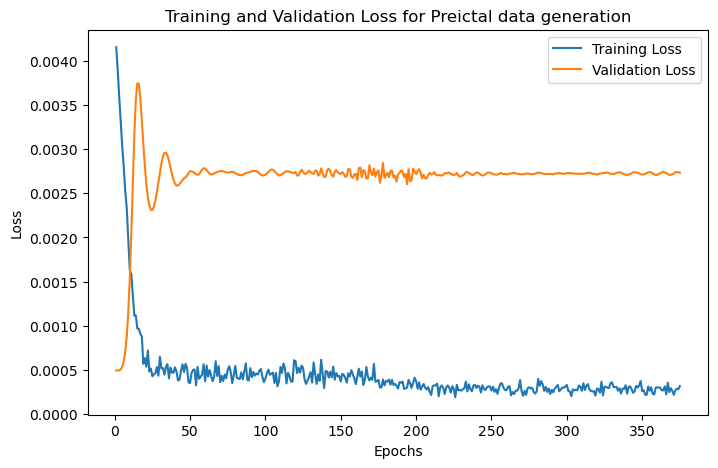

In [50]:
import matplotlib.pyplot as plt

# train_losses_preictal and val_losses_preictal contain the loss values across epochs
# Plotting training and validation loss
epochs = range(1, len(train_losses_preictal) + 1)

plt.figure(figsize=(8, 5))
plt.plot(epochs, train_losses_preictal, label='Training Loss')
plt.plot(epochs, val_losses_preictal, label='Validation Loss')
plt.title('Training and Validation Loss for Preictal data generation')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [51]:
import numpy as np
from torch.utils.data import DataLoader, TensorDataset

# Hyperparameters
input_channels = 16  # NUM_CHANNELS
num_filters = 32
batch_size = 64  # Batch size increased
learning_rate = 0.01 #learning rate increased
num_epochs = 25

# Initialize the model
model_preictal = DDPM(input_channels, num_filters)
criterion = nn.MSELoss()  # Mean Squared Error loss for reconstruction
optimizer = optim.Adam(model_preictal.parameters(), lr=learning_rate)

train_losses_preictal = []
val_losses_preictal = []

# Training loop
for epoch in range(num_epochs):
    # Training
    model_preictal.train()  # Set model to training mode
    for i, (batch_X, _) in enumerate(dataloader):
        
        # Forward pass
        reconstructed = model_preictal(batch_X)
        
        # Calculate loss
        loss = criterion(reconstructed, batch_X)
        
        # Backpropagation and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # Append losses to the lists after each epoch
        train_losses_preictal.append(loss.item())
        
        
        # Print progress
       # print(f"Epoch [{epoch+1}/{num_epochs}], Batch [{i+1}/{len(dataloader)}], Loss: {loss.item()}")
        
        # Validation
        model_preictal.eval()  # Set model to evaluation mode
        val_loss = 0.0
        with torch.no_grad():
            for batch_X_val, _ in val_dataloader:
                reconstructed_val = model_preictal(batch_X_val)
                val_loss += criterion(reconstructed_val, batch_X_val).item()
        val_loss /= len(val_dataloader)
        val_losses_preictal.append(val_loss)

        # Print training and validation loss
        print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {loss.item()}, Validation Loss: {val_loss}")


Epoch [1/25], Train Loss: 0.005651488434523344, Validation Loss: 0.0007026414166815078
Epoch [1/25], Train Loss: 0.0023823590017855167, Validation Loss: 0.014187154281853126
Epoch [1/25], Train Loss: 0.006827794015407562, Validation Loss: 0.0023995428209138267
Epoch [1/25], Train Loss: 0.0006195706664584577, Validation Loss: 0.0006550967115165369
Epoch [1/25], Train Loss: 0.0017112356144934893, Validation Loss: 0.0004221482083549676
Epoch [1/25], Train Loss: 0.002285252558067441, Validation Loss: 0.0004042473848138255
Epoch [1/25], Train Loss: 0.0025269074831157923, Validation Loss: 0.00044888362974249325
Epoch [1/25], Train Loss: 0.0024740141816437244, Validation Loss: 0.0005600549514941527
Epoch [1/25], Train Loss: 0.002156396396458149, Validation Loss: 0.000792909788746512
Epoch [1/25], Train Loss: 0.001940809772349894, Validation Loss: 0.0012280890080263885
Epoch [1/25], Train Loss: 0.0013697471003979445, Validation Loss: 0.001983702390165139
Epoch [1/25], Train Loss: 0.00120557786

Epoch [7/25], Train Loss: 0.00033196850563399494, Validation Loss: 0.002956173282914928
Epoch [7/25], Train Loss: 0.00037561688804998994, Validation Loss: 0.0029638928846463936
Epoch [7/25], Train Loss: 0.00047984858974814415, Validation Loss: 0.0029672012222195124
Epoch [7/25], Train Loss: 0.0004264290037099272, Validation Loss: 0.00296500648622315
Epoch [7/25], Train Loss: 0.00043839795398525894, Validation Loss: 0.0029579492994122394
Epoch [7/25], Train Loss: 0.00045974485692568123, Validation Loss: 0.002947632855336581
Epoch [7/25], Train Loss: 0.0005207651411183178, Validation Loss: 0.0029394503334584108
Epoch [7/25], Train Loss: 0.0005867669824510813, Validation Loss: 0.0029340573926964976
Epoch [7/25], Train Loss: 0.0004184334247838706, Validation Loss: 0.0029314820744692025
Epoch [7/25], Train Loss: 0.0003800309496000409, Validation Loss: 0.002930228938857297
Epoch [7/25], Train Loss: 0.0004591791657730937, Validation Loss: 0.0029310838812414337
Epoch [8/25], Train Loss: 0.0004

Epoch [13/25], Train Loss: 0.0005228117224760354, Validation Loss: 0.00293718116600536
Epoch [13/25], Train Loss: 0.0003461040905676782, Validation Loss: 0.00294490614827691
Epoch [13/25], Train Loss: 0.000517639855388552, Validation Loss: 0.002952612177351443
Epoch [13/25], Train Loss: 0.00037125410744920373, Validation Loss: 0.0029546416466351318
Epoch [13/25], Train Loss: 0.0004966951673850417, Validation Loss: 0.0029535226293002106
Epoch [13/25], Train Loss: 0.00045197593863122165, Validation Loss: 0.0029489503285119764
Epoch [13/25], Train Loss: 0.00041970485472120345, Validation Loss: 0.002940448120377269
Epoch [13/25], Train Loss: 0.0005689170211553574, Validation Loss: 0.002934924405099464
Epoch [14/25], Train Loss: 0.0004349318041931838, Validation Loss: 0.002933371393401332
Epoch [14/25], Train Loss: 0.0004523875250015408, Validation Loss: 0.0029375413589242125
Epoch [14/25], Train Loss: 0.00038567144656553864, Validation Loss: 0.0029424681355628896
Epoch [14/25], Train Loss:

Epoch [19/25], Train Loss: 0.0003805181768257171, Validation Loss: 0.0029340671089736104
Epoch [19/25], Train Loss: 0.0005145164323039353, Validation Loss: 0.0029356689661929085
Epoch [19/25], Train Loss: 0.0004818130692001432, Validation Loss: 0.0029386083200229566
Epoch [19/25], Train Loss: 0.000570605625398457, Validation Loss: 0.00294305695839101
Epoch [19/25], Train Loss: 0.0002606702328193933, Validation Loss: 0.0029449182261219796
Epoch [20/25], Train Loss: 0.00043642264790832996, Validation Loss: 0.0029471622361261552
Epoch [20/25], Train Loss: 0.00032042100792750716, Validation Loss: 0.002946258178215568
Epoch [20/25], Train Loss: 0.00046130959526635706, Validation Loss: 0.0029436999955410217
Epoch [20/25], Train Loss: 0.0005225361092016101, Validation Loss: 0.0029410192148149514
Epoch [20/25], Train Loss: 0.000515047344379127, Validation Loss: 0.0029368791533555803
Epoch [20/25], Train Loss: 0.0004757551068905741, Validation Loss: 0.0029378614697542762
Epoch [20/25], Train Lo

Epoch [25/25], Train Loss: 0.00041258276905864477, Validation Loss: 0.002929305624482887
Epoch [25/25], Train Loss: 0.0005142524605616927, Validation Loss: 0.0029370651850398597


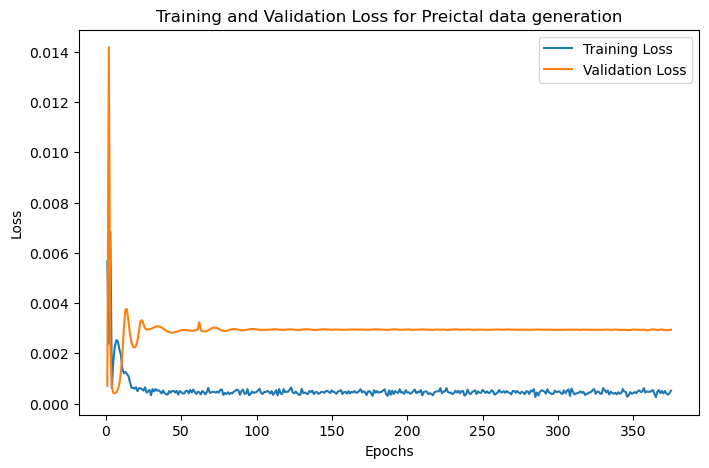

In [52]:
import matplotlib.pyplot as plt

# train_losses_preictal and val_losses_preictal contain the loss values across epochs
# Plotting training and validation loss
epochs = range(1, len(train_losses_preictal) + 1)

plt.figure(figsize=(8, 5))
plt.plot(epochs, train_losses_preictal, label='Training Loss')
plt.plot(epochs, val_losses_preictal, label='Validation Loss')
plt.title('Training and Validation Loss for Preictal data generation')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [59]:
# Hyperparameters
input_channels = 16  # NUM_CHANNELS
num_filters = 32
batch_size = 32  # Batch size changed from 64 to 32 as it's taking a long time to compile
learning_rate = 0.01 #learning rate increased
num_epochs = 25

In [60]:
# Convert training data to PyTorch tensors
X_train_tensor = torch.tensor(X_pre_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_pre_train, dtype=torch.float32)

# Convert validation data to PyTorch tensors
X_val_tensor = torch.tensor(X_pre_val, dtype=torch.float32)
y_val_tensor = torch.tensor(y_pre_val, dtype=torch.float32)

# Create DataLoader for training set
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# Create DataLoader for validation set
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)  # No need to shuffle validation data

In [61]:
import numpy as np
from torch.utils.data import DataLoader, TensorDataset



# Initialize the model
model_preictal = DDPM(input_channels, num_filters)
criterion = nn.MSELoss()  # Mean Squared Error loss for reconstruction
optimizer = optim.Adam(model_preictal.parameters(), lr=learning_rate)

train_losses_preictal = []
val_losses_preictal = []

# Training loop
for epoch in range(num_epochs):
    # Training
    model_preictal.train()  # Set model to training mode
    for i, (batch_X, _) in enumerate(train_dataloader):
        
        # Forward pass
        reconstructed = model_preictal(batch_X)
        
        # Calculate loss
        loss = criterion(reconstructed, batch_X)
        
        # Backpropagation and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # Append losses to the lists after each epoch
        train_losses_preictal.append(loss.item())
        
        
        # Print progress
       # print(f"Epoch [{epoch+1}/{num_epochs}], Batch [{i+1}/{len(dataloader)}], Loss: {loss.item()}")
        
        # Validation
        model_preictal.eval()  # Set model to evaluation mode
        val_loss = 0.0
        with torch.no_grad():
            for batch_X_val, _ in val_dataloader:
                reconstructed_val = model_preictal(batch_X_val)
                val_loss += criterion(reconstructed_val, batch_X_val).item()
        val_loss /= len(val_dataloader)
        val_losses_preictal.append(val_loss)

        # Print training and validation loss
        print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {loss.item()}, Validation Loss: {val_loss}")


Epoch [1/25], Train Loss: 0.0003634310560300946, Validation Loss: 0.00033239719341509043
Epoch [1/25], Train Loss: 0.00035255818511359394, Validation Loss: 0.00022631968895439058
Epoch [1/25], Train Loss: 0.0001784216583473608, Validation Loss: 0.0002294671906080718
Epoch [1/25], Train Loss: 0.00023663591127842665, Validation Loss: 0.00022665416375578691
Epoch [1/25], Train Loss: 0.00018465671746525913, Validation Loss: 0.00021316689332403864
Epoch [1/25], Train Loss: 0.00019479417824186385, Validation Loss: 0.00021958829796252152
Epoch [1/25], Train Loss: 0.00019333513046149164, Validation Loss: 0.00020668123615905643
Epoch [1/25], Train Loss: 0.00023731899273116142, Validation Loss: 0.0002087169739146096
Epoch [1/25], Train Loss: 0.0002358132041990757, Validation Loss: 0.00020799105792927244
Epoch [1/25], Train Loss: 0.00016822638281155378, Validation Loss: 0.00020677670399891213
Epoch [1/25], Train Loss: 0.000167599311680533, Validation Loss: 0.00020703596237581223
Epoch [1/25], Tra

Epoch [1/25], Train Loss: 0.00018491891387384385, Validation Loss: 0.0002058043750973108
Epoch [1/25], Train Loss: 0.00024574811686761677, Validation Loss: 0.0002064545638859272
Epoch [1/25], Train Loss: 0.00014883615949656814, Validation Loss: 0.00020544502864746998
Epoch [1/25], Train Loss: 0.00020448990107979625, Validation Loss: 0.00020489274902502075
Epoch [1/25], Train Loss: 0.00024596680304966867, Validation Loss: 0.00020451515932412196
Epoch [1/25], Train Loss: 0.0001973531034309417, Validation Loss: 0.00020425622448480378
Epoch [1/25], Train Loss: 0.00021249096607789397, Validation Loss: 0.00020478175041110564
Epoch [1/25], Train Loss: 0.00020087895973119885, Validation Loss: 0.00020454388820022966
Epoch [1/25], Train Loss: 0.00014270249812398106, Validation Loss: 0.00020471050035363684
Epoch [1/25], Train Loss: 0.00030888072797097266, Validation Loss: 0.00020481222551704074
Epoch [1/25], Train Loss: 0.00020357640460133553, Validation Loss: 0.00020431058170894783
Epoch [1/25],

Epoch [1/25], Train Loss: 0.00030581504688598216, Validation Loss: 0.00017137238658809412
Epoch [1/25], Train Loss: 0.00016926693206187338, Validation Loss: 0.0002122360902527968
Epoch [1/25], Train Loss: 0.00023403824889101088, Validation Loss: 0.00017340660997433588
Epoch [1/25], Train Loss: 0.00013912658323533833, Validation Loss: 0.00020225828920956702
Epoch [1/25], Train Loss: 0.0002534888335503638, Validation Loss: 0.00018247115998140846
Epoch [1/25], Train Loss: 0.0002173171960748732, Validation Loss: 0.00018348809195837626
Epoch [1/25], Train Loss: 0.00018531843670643866, Validation Loss: 0.0001936939040509363
Epoch [1/25], Train Loss: 0.00018114152771886438, Validation Loss: 0.00017714082835785424
Epoch [1/25], Train Loss: 0.00020532016060315073, Validation Loss: 0.00018735821455872307
Epoch [1/25], Train Loss: 0.00015396549133583903, Validation Loss: 0.00018787704417870069
Epoch [1/25], Train Loss: 0.00021505549375433475, Validation Loss: 0.00017833198968825553
Epoch [1/25], 

Epoch [2/25], Train Loss: 0.00017089488392230123, Validation Loss: 0.00016916813983698377
Epoch [2/25], Train Loss: 0.00020385721290949732, Validation Loss: 0.0001659660925118563
Epoch [2/25], Train Loss: 0.0001672294456511736, Validation Loss: 0.00016694211202169149
Epoch [2/25], Train Loss: 0.00020864751422777772, Validation Loss: 0.00016592981070668127
Epoch [2/25], Train Loss: 0.0002485971199348569, Validation Loss: 0.0001633182939258404
Epoch [2/25], Train Loss: 0.00017064179701264948, Validation Loss: 0.00016430583612721725
Epoch [2/25], Train Loss: 0.00022358205751515925, Validation Loss: 0.00016167127638861228
Epoch [2/25], Train Loss: 0.00018119373999070376, Validation Loss: 0.00016177846385592904
Epoch [2/25], Train Loss: 0.00012697940110228956, Validation Loss: 0.00016047125997526262
Epoch [2/25], Train Loss: 0.0001902818912640214, Validation Loss: 0.0001600316451610221
Epoch [2/25], Train Loss: 0.00014317040040623397, Validation Loss: 0.00015949596830372076
Epoch [2/25], Tr

Epoch [2/25], Train Loss: 0.0002000250678975135, Validation Loss: 0.0001546538941814409
Epoch [2/25], Train Loss: 0.00019771570805460215, Validation Loss: 0.00015466628004408753
Epoch [2/25], Train Loss: 0.0001978820946533233, Validation Loss: 0.0001548545798868872
Epoch [2/25], Train Loss: 0.0001306091871811077, Validation Loss: 0.00015476500387497558
Epoch [2/25], Train Loss: 0.00016831808898132294, Validation Loss: 0.0001545562183309812
Epoch [2/25], Train Loss: 0.00015283857646863908, Validation Loss: 0.0001545580329548102
Epoch [2/25], Train Loss: 0.00011124146840302274, Validation Loss: 0.0001547098159790039
Epoch [2/25], Train Loss: 0.00019045008230023086, Validation Loss: 0.00015471278626743394
Epoch [2/25], Train Loss: 0.00014401214139070362, Validation Loss: 0.00015455818211194128
Epoch [2/25], Train Loss: 0.0001523954706499353, Validation Loss: 0.00015446431595288838
Epoch [2/25], Train Loss: 0.0001662897993810475, Validation Loss: 0.00015447898040292783
Epoch [2/25], Train 

Epoch [2/25], Train Loss: 0.00011433918552938849, Validation Loss: 0.00015291859454009683
Epoch [2/25], Train Loss: 0.0001575723144924268, Validation Loss: 0.0001534944317730454
Epoch [2/25], Train Loss: 0.00015415166853927076, Validation Loss: 0.00015407126678231484
Epoch [2/25], Train Loss: 0.0001725593174342066, Validation Loss: 0.00015398496810424452
Epoch [2/25], Train Loss: 0.00018625080701895058, Validation Loss: 0.00015338037216376202
Epoch [2/25], Train Loss: 0.00016741811123210937, Validation Loss: 0.00015291574964066968
Epoch [2/25], Train Loss: 0.00015159406757447869, Validation Loss: 0.00015270253425114788
Epoch [2/25], Train Loss: 0.00014232630201149732, Validation Loss: 0.00015301487922746068
Epoch [2/25], Train Loss: 0.00013201820547692478, Validation Loss: 0.00015317796326902073
Epoch [2/25], Train Loss: 0.00013645237777382135, Validation Loss: 0.00015320941796138262
Epoch [2/25], Train Loss: 0.00016609681188128889, Validation Loss: 0.00015296877778988953
Epoch [2/25],

Epoch [3/25], Train Loss: 0.0001424458168912679, Validation Loss: 0.00015393471185234375
Epoch [3/25], Train Loss: 0.00011117865506093949, Validation Loss: 0.0001532673804225245
Epoch [3/25], Train Loss: 0.00020806158136110753, Validation Loss: 0.00015179524149668092
Epoch [3/25], Train Loss: 0.00018662330694496632, Validation Loss: 0.00015262023929002073
Epoch [3/25], Train Loss: 0.00010015135194407776, Validation Loss: 0.00015341292770851094
Epoch [3/25], Train Loss: 0.0001921598013723269, Validation Loss: 0.00015245615601694834
Epoch [3/25], Train Loss: 0.00017482566181570292, Validation Loss: 0.00015178023604676128
Epoch [3/25], Train Loss: 0.00011544461449375376, Validation Loss: 0.00015204544203394714
Epoch [3/25], Train Loss: 0.00020311710250098258, Validation Loss: 0.00015244209159088012
Epoch [3/25], Train Loss: 0.00019345809414517134, Validation Loss: 0.00015228773190756328
Epoch [3/25], Train Loss: 0.00015494291437789798, Validation Loss: 0.0001518127020972315
Epoch [3/25], 

Epoch [3/25], Train Loss: 0.00013204845890868455, Validation Loss: 0.00015221934639460719
Epoch [3/25], Train Loss: 0.00014737121819052845, Validation Loss: 0.00015248078101042967
Epoch [3/25], Train Loss: 0.00020919636881444603, Validation Loss: 0.0001521977302521312
Epoch [3/25], Train Loss: 0.0002027151349466294, Validation Loss: 0.00015127029473660514
Epoch [3/25], Train Loss: 0.00014077730884309858, Validation Loss: 0.00015174755947858405
Epoch [3/25], Train Loss: 0.0001606617879588157, Validation Loss: 0.00015301563907996752
Epoch [3/25], Train Loss: 0.00018044516036752611, Validation Loss: 0.00015278726010971392
Epoch [3/25], Train Loss: 0.00017245464550796896, Validation Loss: 0.00015204373048618435
Epoch [3/25], Train Loss: 0.00016363860049750656, Validation Loss: 0.00015083376662611652
Epoch [3/25], Train Loss: 0.00014875127817504108, Validation Loss: 0.00015181483371028056
Epoch [3/25], Train Loss: 0.00012498621072154492, Validation Loss: 0.00015297823459453259
Epoch [3/25],

Epoch [3/25], Train Loss: 0.00017506717995274812, Validation Loss: 0.0001533097689389251
Epoch [3/25], Train Loss: 0.00020754807337652892, Validation Loss: 0.00015066697087604553
Epoch [3/25], Train Loss: 0.00018590390391182154, Validation Loss: 0.0001534113078378141
Epoch [3/25], Train Loss: 0.0001282615412492305, Validation Loss: 0.00015474802567041479
Epoch [3/25], Train Loss: 0.0001310384541284293, Validation Loss: 0.00015159977677588662
Epoch [3/25], Train Loss: 0.00014521651610266417, Validation Loss: 0.00015078735620287868
Epoch [3/25], Train Loss: 0.00017360871424898505, Validation Loss: 0.00015269646100932733
Epoch [3/25], Train Loss: 0.00013398006558418274, Validation Loss: 0.0001522571677924134
Epoch [3/25], Train Loss: 0.00017272790137212723, Validation Loss: 0.0001506903094802207
Epoch [3/25], Train Loss: 0.00017265275528188795, Validation Loss: 0.0001507350127212703
Epoch [3/25], Train Loss: 0.00015102943871170282, Validation Loss: 0.00015193199166484798
Epoch [3/25], Tra

Epoch [4/25], Train Loss: 0.00016232002235483378, Validation Loss: 0.00016470909661923846
Epoch [4/25], Train Loss: 0.00014480046229436994, Validation Loss: 0.0001577498124485525
Epoch [4/25], Train Loss: 0.00017421712982468307, Validation Loss: 0.00016417986698797905
Epoch [4/25], Train Loss: 0.00019673138740472496, Validation Loss: 0.00015760929769991587
Epoch [4/25], Train Loss: 0.00023489708837587386, Validation Loss: 0.00016247600578935816
Epoch [4/25], Train Loss: 0.0001676773972576484, Validation Loss: 0.00015686419186143515
Epoch [4/25], Train Loss: 0.00020741623302455992, Validation Loss: 0.00016082993946232212
Epoch [4/25], Train Loss: 0.00020094790670555085, Validation Loss: 0.00015546255963272415
Epoch [4/25], Train Loss: 0.0001422847853973508, Validation Loss: 0.0001590412832835379
Epoch [4/25], Train Loss: 0.00017350484267808497, Validation Loss: 0.000154398090429216
Epoch [4/25], Train Loss: 0.00017875472258310765, Validation Loss: 0.00015707745236189416
Epoch [4/25], Tr

Epoch [4/25], Train Loss: 0.0001294725079787895, Validation Loss: 0.00014913282672447773
Epoch [4/25], Train Loss: 0.000101738769444637, Validation Loss: 0.00014911035250406713
Epoch [4/25], Train Loss: 0.00014094181824475527, Validation Loss: 0.00014908475228973353
Epoch [4/25], Train Loss: 0.00010703778389142826, Validation Loss: 0.0001490763597151575
Epoch [4/25], Train Loss: 0.00016070055426098406, Validation Loss: 0.00014906311795736353
Epoch [4/25], Train Loss: 0.00015511229867115617, Validation Loss: 0.000149030268463927
Epoch [4/25], Train Loss: 0.00013274919183459133, Validation Loss: 0.00014901733617686357
Epoch [4/25], Train Loss: 0.00012948007497470826, Validation Loss: 0.00014902309558237903
Epoch [4/25], Train Loss: 0.00010930460848612711, Validation Loss: 0.00014901579828195585
Epoch [4/25], Train Loss: 0.00013867588131688535, Validation Loss: 0.0001489778553756575
Epoch [4/25], Train Loss: 0.00011578185512917116, Validation Loss: 0.0001489700475455417
Epoch [4/25], Trai

Epoch [4/25], Train Loss: 0.0001519036595709622, Validation Loss: 0.00014875316483085044
Epoch [4/25], Train Loss: 0.00013550478615798056, Validation Loss: 0.00014867164548680497
Epoch [4/25], Train Loss: 0.0002086464228341356, Validation Loss: 0.0001485173100566802
Epoch [4/25], Train Loss: 0.00014926749281585217, Validation Loss: 0.0001483901030345199
Epoch [4/25], Train Loss: 0.00011650264787022024, Validation Loss: 0.00014841120791970753
Epoch [4/25], Train Loss: 0.00015987054212018847, Validation Loss: 0.00014851739688310773
Epoch [4/25], Train Loss: 0.00014232125249691308, Validation Loss: 0.00014860292891777743
Epoch [4/25], Train Loss: 0.0001503758248873055, Validation Loss: 0.00014858555659884586
Epoch [4/25], Train Loss: 0.00010544514225330204, Validation Loss: 0.00014844723967447255
Epoch [4/25], Train Loss: 0.00018952006939798594, Validation Loss: 0.00014835874705264966
Epoch [4/25], Train Loss: 0.00011272745905444026, Validation Loss: 0.00014830721702310256
Epoch [4/25], T

Epoch [5/25], Train Loss: 0.00014065853611100465, Validation Loss: 0.0001495546952355653
Epoch [5/25], Train Loss: 0.00010166280844714493, Validation Loss: 0.00014850903559514942
Epoch [5/25], Train Loss: 0.00017361775098834187, Validation Loss: 0.00014792503425269387
Epoch [5/25], Train Loss: 0.00013807954383082688, Validation Loss: 0.00014809946684787671
Epoch [5/25], Train Loss: 0.00022236591030377895, Validation Loss: 0.0001485713587802214
Epoch [5/25], Train Loss: 0.00012286807759664953, Validation Loss: 0.00014896304298114653
Epoch [5/25], Train Loss: 0.00010177562944591045, Validation Loss: 0.00014914652395721836
Epoch [5/25], Train Loss: 0.0001815544383134693, Validation Loss: 0.00014901365163192773
Epoch [5/25], Train Loss: 0.00012758684169966727, Validation Loss: 0.00014857667022927974
Epoch [5/25], Train Loss: 0.0001664699229877442, Validation Loss: 0.0001480439265530246
Epoch [5/25], Train Loss: 0.00010876813757931814, Validation Loss: 0.00014783514610220057
Epoch [5/25], T

Epoch [5/25], Train Loss: 0.0001641734124859795, Validation Loss: 0.00016168550428119488
Epoch [5/25], Train Loss: 0.00014981227286625654, Validation Loss: 0.00016505803893475482
Epoch [5/25], Train Loss: 0.00013542953820433468, Validation Loss: 0.00015909438079688698
Epoch [5/25], Train Loss: 0.0001759151928126812, Validation Loss: 0.00014949912995992538
Epoch [5/25], Train Loss: 0.0001456709869671613, Validation Loss: 0.00015031347284093498
Epoch [5/25], Train Loss: 0.0001329995138803497, Validation Loss: 0.0001565131671668496
Epoch [5/25], Train Loss: 0.00019351970695424825, Validation Loss: 0.0001549547589092981
Epoch [5/25], Train Loss: 0.0001484952081227675, Validation Loss: 0.00014881283835469123
Epoch [5/25], Train Loss: 0.00013964387471787632, Validation Loss: 0.0001488570528939211
Epoch [5/25], Train Loss: 0.00013678162940777838, Validation Loss: 0.0001530888660151201
Epoch [5/25], Train Loss: 0.00017081490659620613, Validation Loss: 0.00015314381089410746
Epoch [5/25], Train

Epoch [5/25], Train Loss: 0.00018632219871506095, Validation Loss: 0.000148399486594523
Epoch [5/25], Train Loss: 0.0001258885022252798, Validation Loss: 0.00014812315712333656
Epoch [5/25], Train Loss: 0.00016701828280929476, Validation Loss: 0.00014795319051093733
Epoch [5/25], Train Loss: 0.00014535609807353467, Validation Loss: 0.00014775113328748072
Epoch [5/25], Train Loss: 0.00015880362479947507, Validation Loss: 0.00014758001828643803
Epoch [5/25], Train Loss: 0.00011380184878362343, Validation Loss: 0.0001473948078152413
Epoch [5/25], Train Loss: 0.00020307851082179695, Validation Loss: 0.00014725607300836903
Epoch [5/25], Train Loss: 0.00011798898049164563, Validation Loss: 0.00014713937271153553
Epoch [5/25], Train Loss: 0.0001493001909693703, Validation Loss: 0.00014711384792462923
Epoch [5/25], Train Loss: 0.00017817771004047245, Validation Loss: 0.00014713297011136698
Epoch [5/25], Train Loss: 0.00012004675227217376, Validation Loss: 0.00014716457759883877
Epoch [5/25], T

Epoch [6/25], Train Loss: 0.00011963211727561429, Validation Loss: 0.0001467827445594594
Epoch [6/25], Train Loss: 0.00014622810704167932, Validation Loss: 0.0001467936694098171
Epoch [6/25], Train Loss: 0.00016507258987985551, Validation Loss: 0.00014683607223560103
Epoch [6/25], Train Loss: 0.00021979628945700824, Validation Loss: 0.00014684912772888007
Epoch [6/25], Train Loss: 0.0001042683215928264, Validation Loss: 0.00014682428906477677
Epoch [6/25], Train Loss: 7.56436784286052e-05, Validation Loss: 0.00014678117222501896
Epoch [6/25], Train Loss: 0.00016270454216282815, Validation Loss: 0.00014673770153118918
Epoch [6/25], Train Loss: 0.00010520521755097434, Validation Loss: 0.000146735109835087
Epoch [6/25], Train Loss: 0.00015579340106341988, Validation Loss: 0.00014673716092753844
Epoch [6/25], Train Loss: 0.00017747269885148853, Validation Loss: 0.00014675729131946962
Epoch [6/25], Train Loss: 0.00012451349175535142, Validation Loss: 0.00014677009409448752
Epoch [6/25], Tra

Epoch [6/25], Train Loss: 0.00016642706759739667, Validation Loss: 0.0001481305439180384
Epoch [6/25], Train Loss: 0.00019235926447436213, Validation Loss: 0.00014725252985954286
Epoch [6/25], Train Loss: 0.00019060360500589013, Validation Loss: 0.00014654517581220717
Epoch [6/25], Train Loss: 0.0001507176784798503, Validation Loss: 0.00014644876719103195
Epoch [6/25], Train Loss: 0.00016527606931049377, Validation Loss: 0.00014693628254462964
Epoch [6/25], Train Loss: 0.0001321214804193005, Validation Loss: 0.00014763526705792175
Epoch [6/25], Train Loss: 0.0001320999872405082, Validation Loss: 0.00014862637690384872
Epoch [6/25], Train Loss: 0.0001672440703259781, Validation Loss: 0.00015179199472186155
Epoch [6/25], Train Loss: 0.00017088970344047993, Validation Loss: 0.00015459507606768358
Epoch [6/25], Train Loss: 0.00013229186879470944, Validation Loss: 0.0001566116960020736
Epoch [6/25], Train Loss: 0.00021206292149145156, Validation Loss: 0.00015331385196380628
Epoch [6/25], Tr

Epoch [6/25], Train Loss: 0.000189326805411838, Validation Loss: 0.00014683285238182482
Epoch [6/25], Train Loss: 0.00012023326416965574, Validation Loss: 0.00014622393039947685
Epoch [6/25], Train Loss: 0.0001458666374674067, Validation Loss: 0.0001465496449479057
Epoch [6/25], Train Loss: 0.00022958182671573013, Validation Loss: 0.00014762406499357894
Epoch [6/25], Train Loss: 0.00010248930630041286, Validation Loss: 0.00014905226222860317
Epoch [6/25], Train Loss: 0.00021955804550088942, Validation Loss: 0.0001504412010641924
Epoch [6/25], Train Loss: 0.00010976908379234374, Validation Loss: 0.00015054317846079356
Epoch [6/25], Train Loss: 0.00013531252625398338, Validation Loss: 0.00014950591648812405
Epoch [6/25], Train Loss: 0.00016427574155386537, Validation Loss: 0.0001477399569315215
Epoch [6/25], Train Loss: 0.00015898223500698805, Validation Loss: 0.00014645513680685933
Epoch [6/25], Train Loss: 0.00014468308654613793, Validation Loss: 0.00014623742924110654
Epoch [6/25], Tr

Epoch [7/25], Train Loss: 0.00011388091661501676, Validation Loss: 0.00014775747258681803
Epoch [7/25], Train Loss: 0.0001219494515680708, Validation Loss: 0.00014697583270996498
Epoch [7/25], Train Loss: 0.00021231644495856017, Validation Loss: 0.0001461393985664472
Epoch [7/25], Train Loss: 9.85173464869149e-05, Validation Loss: 0.0001458412705687806
Epoch [7/25], Train Loss: 0.00010893085709540173, Validation Loss: 0.00014606800565767722
Epoch [7/25], Train Loss: 0.00015561399050056934, Validation Loss: 0.00014657936456690852
Epoch [7/25], Train Loss: 0.00012210244312882423, Validation Loss: 0.00014700152605655602
Epoch [7/25], Train Loss: 0.00021426260354928672, Validation Loss: 0.00014756656237295828
Epoch [7/25], Train Loss: 0.00013511189899872988, Validation Loss: 0.0001475693286920432
Epoch [7/25], Train Loss: 0.00012771676119882613, Validation Loss: 0.00014704912052062962
Epoch [7/25], Train Loss: 0.00013625177962239832, Validation Loss: 0.00014630703832760144
Epoch [7/25], Tr

Epoch [7/25], Train Loss: 0.00016862660413607955, Validation Loss: 0.00014600556848260265
Epoch [7/25], Train Loss: 0.000193250467418693, Validation Loss: 0.00014582200698593322
Epoch [7/25], Train Loss: 0.00017025017587002367, Validation Loss: 0.00014563439205327692
Epoch [7/25], Train Loss: 0.0001730356743792072, Validation Loss: 0.0001455033120388786
Epoch [7/25], Train Loss: 0.0001522352104075253, Validation Loss: 0.00014556555906892755
Epoch [7/25], Train Loss: 0.00013740551366936415, Validation Loss: 0.00014570114168842944
Epoch [7/25], Train Loss: 0.00013872564886696637, Validation Loss: 0.00014581227660528384
Epoch [7/25], Train Loss: 0.00012994333519600332, Validation Loss: 0.00014590573991881683
Epoch [7/25], Train Loss: 0.00019775786495301872, Validation Loss: 0.00014604743604043808
Epoch [7/25], Train Loss: 0.00021604931680485606, Validation Loss: 0.00014620545456030717
Epoch [7/25], Train Loss: 0.0001601229450898245, Validation Loss: 0.00014626550352356087
Epoch [7/25], Tr

Epoch [7/25], Train Loss: 0.00010436372394906357, Validation Loss: 0.00014795667617969837
Epoch [7/25], Train Loss: 0.0001592464977875352, Validation Loss: 0.00014846148502935345
Epoch [7/25], Train Loss: 0.00014942655980121344, Validation Loss: 0.00014799493947066368
Epoch [7/25], Train Loss: 0.00012852060899604112, Validation Loss: 0.0001471122850489337
Epoch [7/25], Train Loss: 0.00017312630370724946, Validation Loss: 0.00014597386883300107
Epoch [7/25], Train Loss: 0.00012934916594531387, Validation Loss: 0.00014539997282554397
Epoch [7/25], Train Loss: 0.00016237188538070768, Validation Loss: 0.000145538772388439
Epoch [7/25], Train Loss: 9.091412357520312e-05, Validation Loss: 0.0001460815791991384
Epoch [7/25], Train Loss: 0.0001945667463587597, Validation Loss: 0.00014668304502265527
Epoch [7/25], Train Loss: 0.0001703444286249578, Validation Loss: 0.00014653812662193861
Epoch [7/25], Train Loss: 0.00020618281268980354, Validation Loss: 0.00014657498274270135
Epoch [7/25], Trai

Epoch [8/25], Train Loss: 0.00013625338033307344, Validation Loss: 0.0001471210302649221
Epoch [8/25], Train Loss: 0.00022224037093110383, Validation Loss: 0.00014680686557161
Epoch [8/25], Train Loss: 0.0001426042872481048, Validation Loss: 0.0001460746158651697
Epoch [8/25], Train Loss: 0.000169226826983504, Validation Loss: 0.00014541750182009612
Epoch [8/25], Train Loss: 0.00017162220319733024, Validation Loss: 0.00014507949696659732
Epoch [8/25], Train Loss: 0.0001416995655745268, Validation Loss: 0.00014521126455899018
Epoch [8/25], Train Loss: 0.0001284765312448144, Validation Loss: 0.00014552764938950227
Epoch [8/25], Train Loss: 0.0002015023783314973, Validation Loss: 0.00014574877714039757
Epoch [8/25], Train Loss: 0.0001519390061730519, Validation Loss: 0.00014597466943087057
Epoch [8/25], Train Loss: 0.00015734574117232114, Validation Loss: 0.00014613889482764837
Epoch [8/25], Train Loss: 0.00021185696823522449, Validation Loss: 0.00014672746450135796
Epoch [8/25], Train Lo

Epoch [8/25], Train Loss: 0.00019426169455982745, Validation Loss: 0.0001451306168746669
Epoch [8/25], Train Loss: 0.0001335269771516323, Validation Loss: 0.00014504873082235765
Epoch [8/25], Train Loss: 0.00015928575885482132, Validation Loss: 0.0001457368775542515
Epoch [8/25], Train Loss: 0.0001754953118506819, Validation Loss: 0.00014678301085950806
Epoch [8/25], Train Loss: 0.0001379765017190948, Validation Loss: 0.00014882136795980235
Epoch [8/25], Train Loss: 0.00013878273603040725, Validation Loss: 0.0001497809214924928
Epoch [8/25], Train Loss: 0.0001212346032843925, Validation Loss: 0.00014832217032865932
Epoch [8/25], Train Loss: 0.00017285908688791096, Validation Loss: 0.00014582021370491323
Epoch [8/25], Train Loss: 0.00015170146070886403, Validation Loss: 0.00014539659944906209
Epoch [8/25], Train Loss: 0.00015763762348797172, Validation Loss: 0.00014688799977496576
Epoch [8/25], Train Loss: 0.00011500658001750708, Validation Loss: 0.0001476417989276039
Epoch [8/25], Trai

Epoch [8/25], Train Loss: 0.0002096552780130878, Validation Loss: 0.00014577289063405868
Epoch [8/25], Train Loss: 0.00010386894427938387, Validation Loss: 0.00014606785989599303
Epoch [8/25], Train Loss: 0.0001070046637323685, Validation Loss: 0.0001462334354679721
Epoch [8/25], Train Loss: 0.00013325239706318825, Validation Loss: 0.0001461960404412821
Epoch [8/25], Train Loss: 0.00015877473924774677, Validation Loss: 0.0001458802636382946
Epoch [8/25], Train Loss: 0.00014086891314946115, Validation Loss: 0.00014546307817605946
Epoch [8/25], Train Loss: 0.00020338456670287997, Validation Loss: 0.00014498834449720258
Epoch [8/25], Train Loss: 0.0001424155052518472, Validation Loss: 0.00014474310810328462
Epoch [8/25], Train Loss: 0.00013494418817572296, Validation Loss: 0.0001448376290985228
Epoch [8/25], Train Loss: 0.00016767463239375502, Validation Loss: 0.00014509700510340434
Epoch [8/25], Train Loss: 0.0001405613002134487, Validation Loss: 0.00014532974164467306
Epoch [8/25], Trai

Epoch [9/25], Train Loss: 0.0001510817965026945, Validation Loss: 0.0001447188495755351
Epoch [9/25], Train Loss: 0.00014258231385610998, Validation Loss: 0.0001446730425717154
Epoch [9/25], Train Loss: 0.00018881174037232995, Validation Loss: 0.0001446453524598231
Epoch [9/25], Train Loss: 0.00016146639245562255, Validation Loss: 0.00014465270141954533
Epoch [9/25], Train Loss: 0.000185683136805892, Validation Loss: 0.00014466402814529525
Epoch [9/25], Train Loss: 0.00015498531865887344, Validation Loss: 0.00014463909925931754
Epoch [9/25], Train Loss: 0.0001861237979028374, Validation Loss: 0.00014463888510363176
Epoch [9/25], Train Loss: 0.00015354380593635142, Validation Loss: 0.00014463945335592144
Epoch [9/25], Train Loss: 0.00017114642832893878, Validation Loss: 0.0001446466686805555
Epoch [9/25], Train Loss: 0.00013665558071807027, Validation Loss: 0.00014463226640752205
Epoch [9/25], Train Loss: 0.00016349070938304067, Validation Loss: 0.00014459047937028421
Epoch [9/25], Trai

Epoch [9/25], Train Loss: 0.0001376399741275236, Validation Loss: 0.00015092691052511024
Epoch [9/25], Train Loss: 0.00013210292672738433, Validation Loss: 0.0001541597138081367
Epoch [9/25], Train Loss: 0.00021564614144153893, Validation Loss: 0.0001567924664414022
Epoch [9/25], Train Loss: 0.0001549547305330634, Validation Loss: 0.0001559475424680083
Epoch [9/25], Train Loss: 0.00015354683273471892, Validation Loss: 0.00015145861495208617
Epoch [9/25], Train Loss: 0.00017459662922192365, Validation Loss: 0.0001459675870137289
Epoch [9/25], Train Loss: 0.00013280172424856573, Validation Loss: 0.00014549479116491662
Epoch [9/25], Train Loss: 0.00016320038412231952, Validation Loss: 0.00014862559061536255
Epoch [9/25], Train Loss: 0.00017518196546006948, Validation Loss: 0.0001491064984293189
Epoch [9/25], Train Loss: 0.00020038190996274352, Validation Loss: 0.00014700405663461424
Epoch [9/25], Train Loss: 0.00010174747148994356, Validation Loss: 0.0001449866208228438
Epoch [9/25], Trai

Epoch [9/25], Train Loss: 8.015303319552913e-05, Validation Loss: 0.0001443933540334304
Epoch [9/25], Train Loss: 0.00020224381296429783, Validation Loss: 0.0001444258062595812
Epoch [9/25], Train Loss: 9.718082583276555e-05, Validation Loss: 0.00014445853303186597
Epoch [9/25], Train Loss: 0.00016295048408210278, Validation Loss: 0.00014447006663734403
Epoch [9/25], Train Loss: 0.0001620624534552917, Validation Loss: 0.00014445886481553316
Epoch [9/25], Train Loss: 0.00017366712563671172, Validation Loss: 0.00014443476126568082
Epoch [9/25], Train Loss: 0.00011472505138954148, Validation Loss: 0.00014443627296714112
Epoch [9/25], Train Loss: 0.0001469528506277129, Validation Loss: 0.00014442434864273915
Epoch [9/25], Train Loss: 0.00020270716049708426, Validation Loss: 0.00014441511205707988
Epoch [9/25], Train Loss: 0.00015098026779014617, Validation Loss: 0.00014440528951430073
Epoch [9/25], Train Loss: 0.00012611843703780323, Validation Loss: 0.00014444582532936086
Epoch [9/25], Tr

Epoch [10/25], Train Loss: 0.00017257535364478827, Validation Loss: 0.00014470035093836487
Epoch [10/25], Train Loss: 9.831325587583706e-05, Validation Loss: 0.00014446143977693283
Epoch [10/25], Train Loss: 9.581125777913257e-05, Validation Loss: 0.0001443486912952115
Epoch [10/25], Train Loss: 0.00012378254905343056, Validation Loss: 0.0001443154069420416
Epoch [10/25], Train Loss: 0.0001766304048942402, Validation Loss: 0.0001443343993742019
Epoch [10/25], Train Loss: 0.00014246164937503636, Validation Loss: 0.00014442307462256092
Epoch [10/25], Train Loss: 0.00017347281391266733, Validation Loss: 0.0001444980194113062
Epoch [10/25], Train Loss: 0.0001843161298893392, Validation Loss: 0.00014448326959003074
Epoch [10/25], Train Loss: 0.00018229849229101092, Validation Loss: 0.0001444866761933857
Epoch [10/25], Train Loss: 0.00012436836550477892, Validation Loss: 0.00014449854352278636
Epoch [10/25], Train Loss: 0.00015689799329265952, Validation Loss: 0.0001444763448186374
Epoch [10

Epoch [10/25], Train Loss: 0.00014094298239797354, Validation Loss: 0.00014596982412816336
Epoch [10/25], Train Loss: 0.00010949368879664689, Validation Loss: 0.00014591197832487525
Epoch [10/25], Train Loss: 0.00018220313359051943, Validation Loss: 0.00014579655495860304
Epoch [10/25], Train Loss: 0.0002065880544250831, Validation Loss: 0.00014615856271120719
Epoch [10/25], Train Loss: 0.00010583629045868292, Validation Loss: 0.00014602916441314545
Epoch [10/25], Train Loss: 0.00012734142364934087, Validation Loss: 0.00014538543206678393
Epoch [10/25], Train Loss: 0.00018507275672163814, Validation Loss: 0.00014467257302991737
Epoch [10/25], Train Loss: 0.00014522994752041996, Validation Loss: 0.00014442912603650863
Epoch [10/25], Train Loss: 0.00019177691137883812, Validation Loss: 0.0001447026637227585
Epoch [10/25], Train Loss: 0.00012308471195865422, Validation Loss: 0.00014522259662044234
Epoch [10/25], Train Loss: 0.00018311063467990607, Validation Loss: 0.00014585253350863543
E

Epoch [10/25], Train Loss: 0.0001769584050634876, Validation Loss: 0.00014971435545400405
Epoch [10/25], Train Loss: 0.00012665924441535026, Validation Loss: 0.00014556507885572502
Epoch [10/25], Train Loss: 0.00016557076014578342, Validation Loss: 0.00014515080668691855
Epoch [10/25], Train Loss: 7.05365528119728e-05, Validation Loss: 0.00014935040502071691
Epoch [10/25], Train Loss: 0.00014598306734114885, Validation Loss: 0.00015039988356875257
Epoch [10/25], Train Loss: 0.0002448901068419218, Validation Loss: 0.0001454488214221783
Epoch [10/25], Train Loss: 0.00016952157602645457, Validation Loss: 0.000145367844379507
Epoch [10/25], Train Loss: 0.00020569510525092483, Validation Loss: 0.00014958568426663986
Epoch [10/25], Train Loss: 0.00011306766828056425, Validation Loss: 0.00014878482931332353
Epoch [10/25], Train Loss: 0.00017773699073586613, Validation Loss: 0.000145358774655809
Epoch [10/25], Train Loss: 0.00012324411363806576, Validation Loss: 0.00014511903718812392
Epoch [1

Epoch [11/25], Train Loss: 0.0002325487439520657, Validation Loss: 0.00014407967052344853
Epoch [11/25], Train Loss: 9.926372877089307e-05, Validation Loss: 0.0001440748771225723
Epoch [11/25], Train Loss: 0.00011365874524926767, Validation Loss: 0.00014410185225036305
Epoch [11/25], Train Loss: 0.00011742489732569084, Validation Loss: 0.00014415721088880673
Epoch [11/25], Train Loss: 0.00015456948312930763, Validation Loss: 0.000144211597944377
Epoch [11/25], Train Loss: 9.466538176639006e-05, Validation Loss: 0.00014426173826601976
Epoch [11/25], Train Loss: 0.00012479760334827006, Validation Loss: 0.00014428110443986952
Epoch [11/25], Train Loss: 0.00013792907702736557, Validation Loss: 0.00014430087564202646
Epoch [11/25], Train Loss: 0.00011396044283173978, Validation Loss: 0.00014432814180812177
Epoch [11/25], Train Loss: 0.00011759407789213583, Validation Loss: 0.00014440238956012764
Epoch [11/25], Train Loss: 0.00015917005657684058, Validation Loss: 0.00014443734520076153
Epoch

Epoch [11/25], Train Loss: 0.0002079707628581673, Validation Loss: 0.00014522605609575598
Epoch [11/25], Train Loss: 0.00014408089919015765, Validation Loss: 0.00014537885581376032
Epoch [11/25], Train Loss: 0.0001576208887854591, Validation Loss: 0.00014527527237078174
Epoch [11/25], Train Loss: 0.00018130794342141598, Validation Loss: 0.00014492108675767668
Epoch [11/25], Train Loss: 0.0001555818016640842, Validation Loss: 0.00014453486025255795
Epoch [11/25], Train Loss: 0.0001506309927208349, Validation Loss: 0.00014418655894890737
Epoch [11/25], Train Loss: 0.00017614364332985133, Validation Loss: 0.00014406691892266584
Epoch [11/25], Train Loss: 0.00021735165501013398, Validation Loss: 0.00014411925997895498
Epoch [11/25], Train Loss: 0.00016582572425249964, Validation Loss: 0.00014418238157910915
Epoch [11/25], Train Loss: 0.0001444906956749037, Validation Loss: 0.00014423300575193329
Epoch [11/25], Train Loss: 0.00012393163342494518, Validation Loss: 0.00014430314210282327
Epoc

Epoch [11/25], Train Loss: 0.00014015907072462142, Validation Loss: 0.00014988343294438286
Epoch [11/25], Train Loss: 0.0002415185736026615, Validation Loss: 0.00014847895290586165
Epoch [11/25], Train Loss: 0.00017432386812288314, Validation Loss: 0.0001461533526404916
Epoch [11/25], Train Loss: 0.00015606019587721676, Validation Loss: 0.0001443613315738427
Epoch [11/25], Train Loss: 0.0001423422509105876, Validation Loss: 0.00014425121601865007
Epoch [11/25], Train Loss: 0.00017568515613675117, Validation Loss: 0.0001455179175536614
Epoch [11/25], Train Loss: 0.00014764838851988316, Validation Loss: 0.0001472420034891305
Epoch [11/25], Train Loss: 0.00021491856023203582, Validation Loss: 0.00014843691266529883
Epoch [11/25], Train Loss: 0.00012908471398986876, Validation Loss: 0.0001489694196303996
Epoch [11/25], Train Loss: 9.476118430029601e-05, Validation Loss: 0.0001481816238083411
Epoch [12/25], Train Loss: 9.948848310159519e-05, Validation Loss: 0.0001465406033579105
Epoch [12/

Epoch [12/25], Train Loss: 8.611711382400244e-05, Validation Loss: 0.00014482817205134778
Epoch [12/25], Train Loss: 0.0001332810497842729, Validation Loss: 0.0001450493293911374
Epoch [12/25], Train Loss: 0.00015570342657156289, Validation Loss: 0.00014545664671459236
Epoch [12/25], Train Loss: 0.00017866506823338568, Validation Loss: 0.00014587716408035096
Epoch [12/25], Train Loss: 0.000183042575372383, Validation Loss: 0.00014657798334762143
Epoch [12/25], Train Loss: 0.00015614500443916768, Validation Loss: 0.0001468083132446433
Epoch [12/25], Train Loss: 0.00012532839900813997, Validation Loss: 0.00014644131782309461
Epoch [12/25], Train Loss: 0.00017366069369018078, Validation Loss: 0.00014553407017956488
Epoch [12/25], Train Loss: 0.00013696265523321927, Validation Loss: 0.00014462338246327514
Epoch [12/25], Train Loss: 0.0001260972348973155, Validation Loss: 0.0001439944746380206
Epoch [12/25], Train Loss: 0.00017800847126636654, Validation Loss: 0.00014387456564387928
Epoch [

Epoch [12/25], Train Loss: 0.00011167586490046233, Validation Loss: 0.0001502915130307277
Epoch [12/25], Train Loss: 0.00014637343701906502, Validation Loss: 0.00014921363617759198
Epoch [12/25], Train Loss: 0.00016354367835447192, Validation Loss: 0.00014640139270341023
Epoch [12/25], Train Loss: 0.00014722220657858998, Validation Loss: 0.00014408476951454456
Epoch [12/25], Train Loss: 0.0001532918104203418, Validation Loss: 0.00014456438802881166
Epoch [12/25], Train Loss: 0.0001462689833715558, Validation Loss: 0.00014660008067342764
Epoch [12/25], Train Loss: 0.0001640388072701171, Validation Loss: 0.00014829853122743468
Epoch [12/25], Train Loss: 0.00018611854466143996, Validation Loss: 0.00014758735487703235
Epoch [12/25], Train Loss: 0.0001502906234236434, Validation Loss: 0.00014624461061127174
Epoch [12/25], Train Loss: 0.00010735844261944294, Validation Loss: 0.00014453586530483638
Epoch [12/25], Train Loss: 0.00011516040831338614, Validation Loss: 0.0001439583604224026
Epoch

Epoch [12/25], Train Loss: 0.00010681222920538858, Validation Loss: 0.00014381288541092847
Epoch [12/25], Train Loss: 0.00013208850577939302, Validation Loss: 0.00014377523960623268
Epoch [12/25], Train Loss: 0.00018970703240484, Validation Loss: 0.00014381218376608256
Epoch [12/25], Train Loss: 0.0001330832310486585, Validation Loss: 0.000143897109713483
Epoch [12/25], Train Loss: 0.00020198897982481867, Validation Loss: 0.00014384372843778692
Epoch [13/25], Train Loss: 0.00012476147094275802, Validation Loss: 0.00014397015911526978
Epoch [13/25], Train Loss: 0.00017016839410644025, Validation Loss: 0.00014402603386164022
Epoch [13/25], Train Loss: 0.00015562918270006776, Validation Loss: 0.00014401450801718358
Epoch [13/25], Train Loss: 0.00019855728896800429, Validation Loss: 0.00014390972331360292
Epoch [13/25], Train Loss: 0.00015128517406992614, Validation Loss: 0.00014383155236525152
Epoch [13/25], Train Loss: 0.00012491480447351933, Validation Loss: 0.00014385824761120602
Epoch

Epoch [13/25], Train Loss: 0.00011162937880726531, Validation Loss: 0.00014473607370746322
Epoch [13/25], Train Loss: 9.930595842888579e-05, Validation Loss: 0.00014560436029569245
Epoch [13/25], Train Loss: 0.0001420269109075889, Validation Loss: 0.000145283200739262
Epoch [13/25], Train Loss: 0.0001354575651930645, Validation Loss: 0.000144239779911004
Epoch [13/25], Train Loss: 0.00013409662642516196, Validation Loss: 0.00014414374527405016
Epoch [13/25], Train Loss: 0.00013047376705799252, Validation Loss: 0.00014481770607138362
Epoch [13/25], Train Loss: 0.00015859559061937034, Validation Loss: 0.00014490575461726014
Epoch [13/25], Train Loss: 0.0001743345201248303, Validation Loss: 0.0001445174547067533
Epoch [13/25], Train Loss: 0.00015043762687128037, Validation Loss: 0.00014402889282791876
Epoch [13/25], Train Loss: 0.00013565389963332564, Validation Loss: 0.0001439905827282928
Epoch [13/25], Train Loss: 0.0001469455164624378, Validation Loss: 0.00014431149805507932
Epoch [13/

Epoch [13/25], Train Loss: 0.00012522374163381755, Validation Loss: 0.00014384092234346704
Epoch [13/25], Train Loss: 0.00010857775487238541, Validation Loss: 0.00014405197240800285
Epoch [13/25], Train Loss: 0.00010222806304227561, Validation Loss: 0.00014441724973342693
Epoch [13/25], Train Loss: 0.00013839860912412405, Validation Loss: 0.0001446397315400342
Epoch [13/25], Train Loss: 0.00013941714132670313, Validation Loss: 0.00014458454315899872
Epoch [13/25], Train Loss: 0.00015994839486666024, Validation Loss: 0.0001445427376893349
Epoch [13/25], Train Loss: 0.00015055411495268345, Validation Loss: 0.00014439719234360382
Epoch [13/25], Train Loss: 0.00017151213251054287, Validation Loss: 0.00014418702412513084
Epoch [13/25], Train Loss: 0.00017008843133226037, Validation Loss: 0.00014388697575971795
Epoch [13/25], Train Loss: 0.00013427009980659932, Validation Loss: 0.00014372193739594272
Epoch [13/25], Train Loss: 0.00013152183964848518, Validation Loss: 0.0001437115063405751
Ep

Epoch [14/25], Train Loss: 0.0001290853979298845, Validation Loss: 0.0001440232995567688
Epoch [14/25], Train Loss: 0.00012507666542660445, Validation Loss: 0.00014373570932851482
Epoch [14/25], Train Loss: 0.0001468860573368147, Validation Loss: 0.00014395129813541037
Epoch [14/25], Train Loss: 7.850834663258865e-05, Validation Loss: 0.0001441979887507235
Epoch [14/25], Train Loss: 0.00013113078603055328, Validation Loss: 0.00014437244972214102
Epoch [14/25], Train Loss: 0.00014368750271387398, Validation Loss: 0.0001445620640879497
Epoch [14/25], Train Loss: 0.00015633046859875321, Validation Loss: 0.00014469663486427938
Epoch [14/25], Train Loss: 0.00015170736878644675, Validation Loss: 0.00014480286166265917
Epoch [14/25], Train Loss: 0.00014635888510383666, Validation Loss: 0.0001447319807387733
Epoch [14/25], Train Loss: 0.0001067061020876281, Validation Loss: 0.0001443877149237475
Epoch [14/25], Train Loss: 0.0001765736669767648, Validation Loss: 0.00014412781844536465
Epoch [14

Epoch [14/25], Train Loss: 0.00016400316962972283, Validation Loss: 0.00014586399047402664
Epoch [14/25], Train Loss: 0.00016891890845727175, Validation Loss: 0.00014619666399084963
Epoch [14/25], Train Loss: 0.00016936735482886434, Validation Loss: 0.00014557615237814996
Epoch [14/25], Train Loss: 0.00012901212903670967, Validation Loss: 0.00014457408591018369
Epoch [14/25], Train Loss: 0.00014890830789227039, Validation Loss: 0.00014395609105122276
Epoch [14/25], Train Loss: 0.00015376383089460433, Validation Loss: 0.0001440897016436793
Epoch [14/25], Train Loss: 0.00016428470553364605, Validation Loss: 0.0001442933142243419
Epoch [14/25], Train Loss: 0.00013849491369910538, Validation Loss: 0.0001444838354170012
Epoch [14/25], Train Loss: 0.0001447643298888579, Validation Loss: 0.00014447124534247753
Epoch [14/25], Train Loss: 0.00014491828915197402, Validation Loss: 0.00014424379551201128
Epoch [14/25], Train Loss: 0.0002304125519003719, Validation Loss: 0.00014415547314759655
Epoc

Epoch [14/25], Train Loss: 0.00016256819071713835, Validation Loss: 0.00014368480575891832
Epoch [14/25], Train Loss: 0.00019003677880391479, Validation Loss: 0.00014373791782418266
Epoch [14/25], Train Loss: 0.00017281995678786188, Validation Loss: 0.00014376696684242535
Epoch [14/25], Train Loss: 0.00015812754281796515, Validation Loss: 0.00014384821867376255
Epoch [14/25], Train Loss: 0.00011643766629276797, Validation Loss: 0.00014396724921728795
Epoch [14/25], Train Loss: 0.00010116896737599745, Validation Loss: 0.0001440956060832832
Epoch [14/25], Train Loss: 0.000132805245812051, Validation Loss: 0.00014414033551778024
Epoch [14/25], Train Loss: 9.104367200052366e-05, Validation Loss: 0.00014418634867373233
Epoch [14/25], Train Loss: 0.00018618219473864883, Validation Loss: 0.00014434700739608767
Epoch [14/25], Train Loss: 0.00018640536291059107, Validation Loss: 0.00014448029639121767
Epoch [14/25], Train Loss: 0.0001426104427082464, Validation Loss: 0.0001446576645927659
Epoch

Epoch [15/25], Train Loss: 0.00013210417819209397, Validation Loss: 0.00014486969230347312
Epoch [15/25], Train Loss: 0.0001737370912451297, Validation Loss: 0.00014454070745462862
Epoch [15/25], Train Loss: 0.000253246515057981, Validation Loss: 0.0001440216469442627
Epoch [15/25], Train Loss: 0.0001475902390666306, Validation Loss: 0.00014377013067132794
Epoch [15/25], Train Loss: 0.00015345939027611166, Validation Loss: 0.00014385829175201555
Epoch [15/25], Train Loss: 0.00021732358436565846, Validation Loss: 0.0001441978478396777
Epoch [15/25], Train Loss: 9.426322503713891e-05, Validation Loss: 0.00014466323288312802
Epoch [15/25], Train Loss: 0.0001575163914822042, Validation Loss: 0.00014496197957972374
Epoch [15/25], Train Loss: 0.00016452826093882322, Validation Loss: 0.00014483445217289653
Epoch [15/25], Train Loss: 0.00014227008796297014, Validation Loss: 0.0001447115913227511
Epoch [15/25], Train Loss: 0.0001335109118372202, Validation Loss: 0.0001445338493795134
Epoch [15/

Epoch [15/25], Train Loss: 0.00011792912846431136, Validation Loss: 0.00014482492697425186
Epoch [15/25], Train Loss: 0.0001597574882907793, Validation Loss: 0.0001459628908681528
Epoch [15/25], Train Loss: 0.0001531977322883904, Validation Loss: 0.00014745595884354165
Epoch [15/25], Train Loss: 0.0002012234035646543, Validation Loss: 0.00014982413170703998
Epoch [15/25], Train Loss: 0.00013950681022834033, Validation Loss: 0.0001511034851622147
Epoch [15/25], Train Loss: 0.00013721580035053194, Validation Loss: 0.00015071077771911708
Epoch [15/25], Train Loss: 0.00016677648818586022, Validation Loss: 0.00014720173324652328
Epoch [15/25], Train Loss: 0.00010024952644016594, Validation Loss: 0.00014424519686144776
Epoch [15/25], Train Loss: 0.0001601845578989014, Validation Loss: 0.00014457018939234938
Epoch [15/25], Train Loss: 0.0001712135854177177, Validation Loss: 0.00014659503406922643
Epoch [15/25], Train Loss: 0.00015668377454858273, Validation Loss: 0.00014698263839818537
Epoch 

Epoch [15/25], Train Loss: 0.00014898204244673252, Validation Loss: 0.00014359740016516297
Epoch [15/25], Train Loss: 0.0001981795358005911, Validation Loss: 0.0001436471002913701
Epoch [15/25], Train Loss: 0.00014355932944454253, Validation Loss: 0.0001437240069208201
Epoch [15/25], Train Loss: 0.00014557257236447185, Validation Loss: 0.0001438169407871707
Epoch [15/25], Train Loss: 0.00015752902254462242, Validation Loss: 0.000143942177722541
Epoch [15/25], Train Loss: 0.00020132158533670008, Validation Loss: 0.00014411589654628187
Epoch [15/25], Train Loss: 0.00013155894703231752, Validation Loss: 0.00014408495868944253
Epoch [15/25], Train Loss: 0.00014959866530261934, Validation Loss: 0.00014400511475590367
Epoch [15/25], Train Loss: 0.00017508305609226227, Validation Loss: 0.0001440423356446748
Epoch [15/25], Train Loss: 0.00013169573503546417, Validation Loss: 0.0001441180625988636
Epoch [15/25], Train Loss: 0.00018444351735524833, Validation Loss: 0.00014419563788881836
Epoch [

Epoch [16/25], Train Loss: 0.00015522488683927804, Validation Loss: 0.00014394588385281774
Epoch [16/25], Train Loss: 0.00012837313988711685, Validation Loss: 0.00014419435829040594
Epoch [16/25], Train Loss: 0.00011272253323113546, Validation Loss: 0.0001440575123221303
Epoch [16/25], Train Loss: 0.00012105663336114958, Validation Loss: 0.0001441268927010242
Epoch [16/25], Train Loss: 0.00012711307499557734, Validation Loss: 0.00014413262033485807
Epoch [16/25], Train Loss: 0.00014412819291464984, Validation Loss: 0.0001439978009633099
Epoch [16/25], Train Loss: 0.000166357567650266, Validation Loss: 0.000143979316635523
Epoch [16/25], Train Loss: 9.153733117273077e-05, Validation Loss: 0.00014387142170259418
Epoch [16/25], Train Loss: 0.0001832552661653608, Validation Loss: 0.00014376089990643474
Epoch [16/25], Train Loss: 9.296854113927111e-05, Validation Loss: 0.00014369643686222843
Epoch [16/25], Train Loss: 0.000157272006617859, Validation Loss: 0.00014361236559731576
Epoch [16/2

Epoch [16/25], Train Loss: 9.732653415994719e-05, Validation Loss: 0.0001435768193914555
Epoch [16/25], Train Loss: 0.00015264746616594493, Validation Loss: 0.00014360415710446735
Epoch [16/25], Train Loss: 0.00015242195513565093, Validation Loss: 0.0001435383678957199
Epoch [16/25], Train Loss: 0.00020605532336048782, Validation Loss: 0.00014349514361432133
Epoch [16/25], Train Loss: 0.00011205570626771078, Validation Loss: 0.0001435148427844979
Epoch [16/25], Train Loss: 0.00012109969247831032, Validation Loss: 0.0001435479149222374
Epoch [16/25], Train Loss: 0.00020331921405158937, Validation Loss: 0.00014351324862218461
Epoch [16/25], Train Loss: 0.00013600535748992115, Validation Loss: 0.00014348234568994182
Epoch [16/25], Train Loss: 0.00011272868869127706, Validation Loss: 0.00014351629627829728
Epoch [16/25], Train Loss: 0.0001894613087642938, Validation Loss: 0.0001436249614926055
Epoch [16/25], Train Loss: 0.0001421801425749436, Validation Loss: 0.00014353698934428395
Epoch [

Epoch [16/25], Train Loss: 0.00011955187801504508, Validation Loss: 0.0001461017881714118
Epoch [16/25], Train Loss: 0.00014863797696307302, Validation Loss: 0.00014582024305127562
Epoch [16/25], Train Loss: 0.00019488594261929393, Validation Loss: 0.00014499947307437347
Epoch [16/25], Train Loss: 0.0002130233042407781, Validation Loss: 0.00014397704411142815
Epoch [16/25], Train Loss: 0.00016355514526367188, Validation Loss: 0.00014365512712781006
Epoch [16/25], Train Loss: 0.00014829881547484547, Validation Loss: 0.00014406746364935922
Epoch [16/25], Train Loss: 0.00013868097448721528, Validation Loss: 0.0001447508308046963
Epoch [16/25], Train Loss: 0.00015367154264822602, Validation Loss: 0.00014523413992719724
Epoch [16/25], Train Loss: 0.00013766229676548392, Validation Loss: 0.0001449756001723775
Epoch [16/25], Train Loss: 0.00015246255497913808, Validation Loss: 0.0001445038656432492
Epoch [16/25], Train Loss: 0.00015791854821145535, Validation Loss: 0.00014395440909235427
Epoc

Epoch [17/25], Train Loss: 0.00013295249664224684, Validation Loss: 0.00014344808732857928
Epoch [17/25], Train Loss: 0.00014296866720542312, Validation Loss: 0.00014340611669467763
Epoch [17/25], Train Loss: 0.000203967239940539, Validation Loss: 0.00014346784106843795
Epoch [17/25], Train Loss: 0.00015556700236629695, Validation Loss: 0.00014355809034896083
Epoch [17/25], Train Loss: 0.0002402012178208679, Validation Loss: 0.00014382138300182609
Epoch [17/25], Train Loss: 0.00018398613610770553, Validation Loss: 0.00014415981228618573
Epoch [17/25], Train Loss: 0.00017238035798072815, Validation Loss: 0.00014440005834330804
Epoch [17/25], Train Loss: 0.000173347580130212, Validation Loss: 0.0001446457458465981
Epoch [17/25], Train Loss: 0.00021096183627378196, Validation Loss: 0.0001452328823991896
Epoch [17/25], Train Loss: 0.00014851389278192073, Validation Loss: 0.00014617693692950222
Epoch [17/25], Train Loss: 0.00015770705067552626, Validation Loss: 0.000146826633620852
Epoch [1

Epoch [17/25], Train Loss: 0.00015237317711580545, Validation Loss: 0.0001443254327265701
Epoch [17/25], Train Loss: 0.0001723461609799415, Validation Loss: 0.00014496536144482282
Epoch [17/25], Train Loss: 0.00018709103460423648, Validation Loss: 0.000145703036832856
Epoch [17/25], Train Loss: 0.0001566274295328185, Validation Loss: 0.00014581046731715713
Epoch [17/25], Train Loss: 0.00011043879931094125, Validation Loss: 0.00014665940131332414
Epoch [17/25], Train Loss: 0.00012781676196027547, Validation Loss: 0.00014704151205175247
Epoch [17/25], Train Loss: 0.0001826836378313601, Validation Loss: 0.0001467502343681796
Epoch [17/25], Train Loss: 0.0001616685331100598, Validation Loss: 0.00014623505703639239
Epoch [17/25], Train Loss: 0.00014887894212733954, Validation Loss: 0.0001442786400730256
Epoch [17/25], Train Loss: 0.0001516271149739623, Validation Loss: 0.00014360739248028647
Epoch [17/25], Train Loss: 0.00011343751975800842, Validation Loss: 0.00014470962802685486
Epoch [17

Epoch [17/25], Train Loss: 0.00011553427611943334, Validation Loss: 0.00014348734039231202
Epoch [17/25], Train Loss: 0.0001599214447196573, Validation Loss: 0.0001439809479052201
Epoch [17/25], Train Loss: 0.00012030385551042855, Validation Loss: 0.0001445969821361359
Epoch [17/25], Train Loss: 0.00014051978359930217, Validation Loss: 0.00014468583976849913
Epoch [17/25], Train Loss: 0.00014974211808294058, Validation Loss: 0.00014443915230610098
Epoch [17/25], Train Loss: 0.00015695152978878468, Validation Loss: 0.0001440698290631796
Epoch [17/25], Train Loss: 0.00017821892106439918, Validation Loss: 0.0001436773430517254
Epoch [17/25], Train Loss: 0.00011961668496951461, Validation Loss: 0.0001434418171508393
Epoch [17/25], Train Loss: 0.00010571553866611794, Validation Loss: 0.00014349443808896466
Epoch [17/25], Train Loss: 0.0001227019092766568, Validation Loss: 0.0001437723253426763
Epoch [17/25], Train Loss: 0.0002360792859690264, Validation Loss: 0.0001440511007482807
Epoch [17

Epoch [18/25], Train Loss: 0.00013499819033313543, Validation Loss: 0.0001457866967636316
Epoch [18/25], Train Loss: 0.00016183665138669312, Validation Loss: 0.0001437542193646853
Epoch [18/25], Train Loss: 0.00016680409316904843, Validation Loss: 0.00014424889498817114
Epoch [18/25], Train Loss: 0.00011315932351863012, Validation Loss: 0.000145903461331424
Epoch [18/25], Train Loss: 0.00017894397024065256, Validation Loss: 0.00014700955798616633
Epoch [18/25], Train Loss: 0.00014657578140031546, Validation Loss: 0.00014624938388199855
Epoch [18/25], Train Loss: 0.0001241822901647538, Validation Loss: 0.00014477560204492572
Epoch [18/25], Train Loss: 0.00010776452836580575, Validation Loss: 0.00014376742547028698
Epoch [18/25], Train Loss: 0.00014137481048237532, Validation Loss: 0.00014372112612666874
Epoch [18/25], Train Loss: 0.00013010673865210265, Validation Loss: 0.00014440888238217062
Epoch [18/25], Train Loss: 0.00016780401347205043, Validation Loss: 0.00014528918642705928
Epoc

Epoch [18/25], Train Loss: 0.00011287406232440844, Validation Loss: 0.00014425015178858301
Epoch [18/25], Train Loss: 0.0001327680511167273, Validation Loss: 0.00014466005256205487
Epoch [18/25], Train Loss: 0.0001970660377992317, Validation Loss: 0.00014475193796291327
Epoch [18/25], Train Loss: 0.00018554281268734485, Validation Loss: 0.00014516697168195
Epoch [18/25], Train Loss: 0.00017031232709996402, Validation Loss: 0.00014502794147119857
Epoch [18/25], Train Loss: 0.0001474826131016016, Validation Loss: 0.00014460420376659992
Epoch [18/25], Train Loss: 0.0001866278616944328, Validation Loss: 0.00014422142727804992
Epoch [18/25], Train Loss: 0.0001192568670376204, Validation Loss: 0.00014398471321328544
Epoch [18/25], Train Loss: 0.00015307695139199495, Validation Loss: 0.00014366572601526666
Epoch [18/25], Train Loss: 0.00011619538418017328, Validation Loss: 0.00014344322286585036
Epoch [18/25], Train Loss: 0.00015144547796808183, Validation Loss: 0.00014338253313326277
Epoch [

Epoch [18/25], Train Loss: 0.00017408555140718818, Validation Loss: 0.00019084974725653108
Epoch [18/25], Train Loss: 0.00027028031763620675, Validation Loss: 0.00018994872662005945
Epoch [18/25], Train Loss: 0.00022376210836227983, Validation Loss: 0.0001883080811239779
Epoch [18/25], Train Loss: 0.0001874501904239878, Validation Loss: 0.00018525616421053806
Epoch [18/25], Train Loss: 0.0001680974237388, Validation Loss: 0.00018450803157368985
Epoch [18/25], Train Loss: 0.0001521263038739562, Validation Loss: 0.00018346140035040056
Epoch [18/25], Train Loss: 0.00021376690710894763, Validation Loss: 0.00018239876687099846
Epoch [18/25], Train Loss: 0.00021078568533994257, Validation Loss: 0.00018667406014477212
Epoch [18/25], Train Loss: 0.00025353586534038186, Validation Loss: 0.00018299893902925154
Epoch [18/25], Train Loss: 0.00015972068649716675, Validation Loss: 0.00017735888832248747
Epoch [18/25], Train Loss: 0.00017169902275782079, Validation Loss: 0.00017625347754801624
Epoch 

Epoch [19/25], Train Loss: 0.0001426589151378721, Validation Loss: 0.00014678710819377255
Epoch [19/25], Train Loss: 0.00013225592556409538, Validation Loss: 0.00014687777608439015
Epoch [19/25], Train Loss: 9.358415263704956e-05, Validation Loss: 0.00014686350768897683
Epoch [19/25], Train Loss: 0.00017464542179368436, Validation Loss: 0.00014681222431439284
Epoch [19/25], Train Loss: 0.0002220995374955237, Validation Loss: 0.00014669921171541015
Epoch [19/25], Train Loss: 0.0001444742811145261, Validation Loss: 0.0001466663617369098
Epoch [19/25], Train Loss: 0.00016253696230705827, Validation Loss: 0.00014668956476574142
Epoch [19/25], Train Loss: 0.00017403702076990157, Validation Loss: 0.00014665905667546515
Epoch [19/25], Train Loss: 0.00011935584188904613, Validation Loss: 0.00014657404196138183
Epoch [19/25], Train Loss: 0.00021454706438817084, Validation Loss: 0.0001465839343533541
Epoch [19/25], Train Loss: 0.00013434466382022947, Validation Loss: 0.000146727833392409
Epoch [

Epoch [19/25], Train Loss: 0.00015538415755145252, Validation Loss: 0.00014562023546507892
Epoch [19/25], Train Loss: 0.00015528485528193414, Validation Loss: 0.00014567953354950683
Epoch [19/25], Train Loss: 0.00020189864153508097, Validation Loss: 0.00014568991731114995
Epoch [19/25], Train Loss: 0.00015066836203914136, Validation Loss: 0.00014565994812680097
Epoch [19/25], Train Loss: 0.0001470951538067311, Validation Loss: 0.00014567586816459274
Epoch [19/25], Train Loss: 0.0002036412915913388, Validation Loss: 0.0001456454883737024
Epoch [19/25], Train Loss: 0.00010944021050818264, Validation Loss: 0.00014564752321651517
Epoch [19/25], Train Loss: 8.9774199295789e-05, Validation Loss: 0.000145675763633335
Epoch [19/25], Train Loss: 0.0001849638792918995, Validation Loss: 0.00014560219206032342
Epoch [19/25], Train Loss: 0.00011697533773258328, Validation Loss: 0.0001455751723066593
Epoch [19/25], Train Loss: 0.00022175376943778247, Validation Loss: 0.00014559475772936518
Epoch [19

Epoch [19/25], Train Loss: 0.00016722861619200557, Validation Loss: 0.00014621285736211577
Epoch [19/25], Train Loss: 0.00011337612522765994, Validation Loss: 0.00014617367972581026
Epoch [19/25], Train Loss: 0.00017727921658661216, Validation Loss: 0.00014606410598692795
Epoch [19/25], Train Loss: 0.0001725565962260589, Validation Loss: 0.00014615891923313028
Epoch [19/25], Train Loss: 0.00015960572636686265, Validation Loss: 0.00014631409576395526
Epoch [19/25], Train Loss: 0.00013463411596603692, Validation Loss: 0.00014600096110370942
Epoch [19/25], Train Loss: 0.00021369206660892814, Validation Loss: 0.00014586715333280152
Epoch [19/25], Train Loss: 0.00019360604346729815, Validation Loss: 0.0001459002887713723
Epoch [19/25], Train Loss: 0.00016654428327456117, Validation Loss: 0.00014572551032567086
Epoch [19/25], Train Loss: 0.0001792946713976562, Validation Loss: 0.00014546202946803534
Epoch [19/25], Train Loss: 0.00021137925796210766, Validation Loss: 0.00014545931844622828
Ep

Epoch [20/25], Train Loss: 0.00012666836846619844, Validation Loss: 0.00014679053395714922
Epoch [20/25], Train Loss: 0.00014883225958328694, Validation Loss: 0.00014546407255693338
Epoch [20/25], Train Loss: 0.00014330711564980447, Validation Loss: 0.00014513509086100385
Epoch [20/25], Train Loss: 0.00017839430074673146, Validation Loss: 0.00014596853022036765
Epoch [20/25], Train Loss: 0.0001450981799280271, Validation Loss: 0.00014708401383055995
Epoch [20/25], Train Loss: 0.0001863617217168212, Validation Loss: 0.00014672117516359624
Epoch [20/25], Train Loss: 0.00014476665819529444, Validation Loss: 0.00014572771615348757
Epoch [20/25], Train Loss: 0.00016506400424987078, Validation Loss: 0.00014530201830590764
Epoch [20/25], Train Loss: 0.0001683371519902721, Validation Loss: 0.0001454080265830271
Epoch [20/25], Train Loss: 0.00015995105786714703, Validation Loss: 0.0001457902464608196
Epoch [20/25], Train Loss: 0.00019229642930440605, Validation Loss: 0.0001460929942065074
Epoch

Epoch [20/25], Train Loss: 0.00018201518105342984, Validation Loss: 0.0001452002295991406
Epoch [20/25], Train Loss: 0.00013774234685115516, Validation Loss: 0.000145323621109128
Epoch [20/25], Train Loss: 0.00014715723227709532, Validation Loss: 0.00014540384969829271
Epoch [20/25], Train Loss: 0.00017485937860328704, Validation Loss: 0.0001456276583970369
Epoch [20/25], Train Loss: 0.0001634134678170085, Validation Loss: 0.0001457539425852398
Epoch [20/25], Train Loss: 0.00011799558706115931, Validation Loss: 0.00014594775299580457
Epoch [20/25], Train Loss: 0.00013566661800723523, Validation Loss: 0.0001460393495411457
Epoch [20/25], Train Loss: 0.00013259754632599652, Validation Loss: 0.00014615300509224956
Epoch [20/25], Train Loss: 0.00022837150027044117, Validation Loss: 0.00014657845022156835
Epoch [20/25], Train Loss: 0.00011518981045810506, Validation Loss: 0.00014656591544432256
Epoch [20/25], Train Loss: 0.00013166212011128664, Validation Loss: 0.00014675113658692377
Epoch 

Epoch [20/25], Train Loss: 0.00017204933101311326, Validation Loss: 0.00014549882374315833
Epoch [20/25], Train Loss: 0.00022785071632824838, Validation Loss: 0.000145135999143046
Epoch [20/25], Train Loss: 0.00020122859859839082, Validation Loss: 0.00014551033794608277
Epoch [20/25], Train Loss: 0.00011286180233582854, Validation Loss: 0.00014571935729084846
Epoch [20/25], Train Loss: 0.0001540695084258914, Validation Loss: 0.00014563851145794616
Epoch [20/25], Train Loss: 0.0001437240862287581, Validation Loss: 0.0001450182465002096
Epoch [20/25], Train Loss: 0.00016681267879903316, Validation Loss: 0.00014508823078358547
Epoch [20/25], Train Loss: 0.00019393190450500697, Validation Loss: 0.00014540185487324682
Epoch [20/25], Train Loss: 0.00014839100185781717, Validation Loss: 0.00014526146987918763
Epoch [20/25], Train Loss: 0.00012091192184016109, Validation Loss: 0.00014525245496770366
Epoch [20/25], Train Loss: 0.00021205240045674145, Validation Loss: 0.00014482385959126986
Epoc

Epoch [21/25], Train Loss: 0.0001576370996190235, Validation Loss: 0.00014462310258143892
Epoch [21/25], Train Loss: 0.0001389700046274811, Validation Loss: 0.0001454931819656243
Epoch [21/25], Train Loss: 0.00016925497038755566, Validation Loss: 0.0001465487456395446
Epoch [21/25], Train Loss: 0.00011023685510735959, Validation Loss: 0.00014600817521568388
Epoch [21/25], Train Loss: 0.00019678474927786738, Validation Loss: 0.00014468574348332672
Epoch [21/25], Train Loss: 0.00015980994794517756, Validation Loss: 0.0001445346524027021
Epoch [21/25], Train Loss: 0.0001587679871590808, Validation Loss: 0.00014531488147137377
Epoch [21/25], Train Loss: 0.0001574748457642272, Validation Loss: 0.00014571762148989363
Epoch [21/25], Train Loss: 0.00014760802150703967, Validation Loss: 0.00014534592895264117
Epoch [21/25], Train Loss: 0.0002172357781091705, Validation Loss: 0.00014475070420303383
Epoch [21/25], Train Loss: 0.0002000209060497582, Validation Loss: 0.00014454102177599755
Epoch [2

Epoch [21/25], Train Loss: 0.00014340273628477007, Validation Loss: 0.00014516641458612868
Epoch [21/25], Train Loss: 0.000163257573149167, Validation Loss: 0.0001506706525105983
Epoch [21/25], Train Loss: 0.00013196977670304477, Validation Loss: 0.00015191507579099078
Epoch [21/25], Train Loss: 0.000154467998072505, Validation Loss: 0.00014529818314864922
Epoch [21/25], Train Loss: 0.00011500323307700455, Validation Loss: 0.00014878656850972523
Epoch [21/25], Train Loss: 0.00013968507118988782, Validation Loss: 0.00015137533143085117
Epoch [21/25], Train Loss: 0.00012478728604037315, Validation Loss: 0.0001456500812006804
Epoch [21/25], Train Loss: 0.0001535647315904498, Validation Loss: 0.00014689940289827063
Epoch [21/25], Train Loss: 0.00017481351096648723, Validation Loss: 0.00015050361980684102
Epoch [21/25], Train Loss: 0.00018211045244242996, Validation Loss: 0.00014622219678130932
Epoch [21/25], Train Loss: 0.00012006497127003968, Validation Loss: 0.0001457307019639605
Epoch [

Epoch [21/25], Train Loss: 0.0001796217547962442, Validation Loss: 0.0001442782682715915
Epoch [21/25], Train Loss: 0.0001509779685875401, Validation Loss: 0.0001443299394547163
Epoch [21/25], Train Loss: 0.00015288955182768404, Validation Loss: 0.0001441687338228803
Epoch [21/25], Train Loss: 0.0001729268697090447, Validation Loss: 0.00014431488186043376
Epoch [21/25], Train Loss: 0.00014831923181191087, Validation Loss: 0.00014430204707120234
Epoch [21/25], Train Loss: 0.00013388012303039432, Validation Loss: 0.00014421824453165756
Epoch [21/25], Train Loss: 0.00012041953596053645, Validation Loss: 0.0001443794021421733
Epoch [21/25], Train Loss: 0.00014639689470641315, Validation Loss: 0.0001443470976179621
Epoch [21/25], Train Loss: 0.00017525900329928845, Validation Loss: 0.00014422046006075108
Epoch [21/25], Train Loss: 0.00015818803512956947, Validation Loss: 0.00014424492183024996
Epoch [21/25], Train Loss: 0.00014390864816959947, Validation Loss: 0.00014418941912784552
Epoch [

Epoch [22/25], Train Loss: 0.00015301405801437795, Validation Loss: 0.00014411597585421986
Epoch [22/25], Train Loss: 0.00010386513167759404, Validation Loss: 0.00014410965911035116
Epoch [22/25], Train Loss: 0.00011017010547220707, Validation Loss: 0.00014407657023790915
Epoch [22/25], Train Loss: 0.0001415337173966691, Validation Loss: 0.00014407582542238137
Epoch [22/25], Train Loss: 0.0001354848500341177, Validation Loss: 0.0001440915582255305
Epoch [22/25], Train Loss: 0.0001767056091921404, Validation Loss: 0.00014408912878328313
Epoch [22/25], Train Loss: 0.00011064670252380893, Validation Loss: 0.00014408859497052617
Epoch [22/25], Train Loss: 0.00014822349476162344, Validation Loss: 0.00014405745459953324
Epoch [22/25], Train Loss: 0.0001509407302364707, Validation Loss: 0.00014402904780581595
Epoch [22/25], Train Loss: 0.00017424691759515554, Validation Loss: 0.00014406527698156423
Epoch [22/25], Train Loss: 0.0001419564214302227, Validation Loss: 0.0001440538673098975
Epoch 

Epoch [22/25], Train Loss: 0.00018370871839579195, Validation Loss: 0.00014419157426649084
Epoch [22/25], Train Loss: 0.00017907272558659315, Validation Loss: 0.00014411298446551275
Epoch [22/25], Train Loss: 0.00015549974341411144, Validation Loss: 0.00014401208221291503
Epoch [22/25], Train Loss: 0.00019120294018648565, Validation Loss: 0.00014432309205100562
Epoch [22/25], Train Loss: 0.00017247286450583488, Validation Loss: 0.00014414039615076035
Epoch [22/25], Train Loss: 0.0001458135520806536, Validation Loss: 0.00014411308050815325
Epoch [22/25], Train Loss: 0.0001711963559500873, Validation Loss: 0.00014445157648879103
Epoch [22/25], Train Loss: 0.00013031542766839266, Validation Loss: 0.00014414868176875945
Epoch [22/25], Train Loss: 0.00015316544158849865, Validation Loss: 0.00014406356179582266
Epoch [22/25], Train Loss: 0.00020130295888520777, Validation Loss: 0.00014408455729911414
Epoch [22/25], Train Loss: 0.00015723667456768453, Validation Loss: 0.0001441950742446352
Ep

Epoch [22/25], Train Loss: 0.0001503292005509138, Validation Loss: 0.0001439978174554805
Epoch [22/25], Train Loss: 0.00015444385644514114, Validation Loss: 0.000143972753721755
Epoch [22/25], Train Loss: 0.00012070775119354948, Validation Loss: 0.00014392935360471408
Epoch [22/25], Train Loss: 0.00017402514640707523, Validation Loss: 0.0001439908587296183
Epoch [22/25], Train Loss: 0.00016331177903339267, Validation Loss: 0.00014401993418384034
Epoch [22/25], Train Loss: 0.0001599126699147746, Validation Loss: 0.00014398379498743453
Epoch [22/25], Train Loss: 0.00016905223310459405, Validation Loss: 0.00014420025787937146
Epoch [22/25], Train Loss: 0.00017291682888753712, Validation Loss: 0.0001444619478813062
Epoch [22/25], Train Loss: 0.00013471826969180256, Validation Loss: 0.00014431960759490417
Epoch [22/25], Train Loss: 0.0001612564956303686, Validation Loss: 0.0001445089406236851
Epoch [22/25], Train Loss: 0.00019651444745250046, Validation Loss: 0.00014484996839504068
Epoch [2

Epoch [23/25], Train Loss: 0.00013933285663370043, Validation Loss: 0.00014466444141968774
Epoch [23/25], Train Loss: 0.0001303034950979054, Validation Loss: 0.00014492299960693343
Epoch [23/25], Train Loss: 0.00017784697411116213, Validation Loss: 0.00014511820966921126
Epoch [23/25], Train Loss: 0.00011900652316398919, Validation Loss: 0.00014544610166922212
Epoch [23/25], Train Loss: 0.00016361207235604525, Validation Loss: 0.0001458855163946282
Epoch [23/25], Train Loss: 0.00017472801846452057, Validation Loss: 0.0001464646920794621
Epoch [23/25], Train Loss: 0.00011217834253329784, Validation Loss: 0.0001468322596338112
Epoch [23/25], Train Loss: 0.00014542667486239225, Validation Loss: 0.00014740589782983685
Epoch [23/25], Train Loss: 0.000124146492453292, Validation Loss: 0.00014757613292507206
Epoch [23/25], Train Loss: 0.00012810048065148294, Validation Loss: 0.00014773266472426863
Epoch [23/25], Train Loss: 0.00015066486957948655, Validation Loss: 0.00014727554177322114
Epoch

Epoch [23/25], Train Loss: 0.00011363771045580506, Validation Loss: 0.0001439501254935749
Epoch [23/25], Train Loss: 0.00019914732547476888, Validation Loss: 0.00014405206044709
Epoch [23/25], Train Loss: 0.00011821128282463178, Validation Loss: 0.00014404239530752723
Epoch [23/25], Train Loss: 0.0001371586840832606, Validation Loss: 0.0001442070444075701
Epoch [23/25], Train Loss: 0.00014794326853007078, Validation Loss: 0.0001439777018579965
Epoch [23/25], Train Loss: 0.00015396643721032888, Validation Loss: 0.00014411770025617442
Epoch [23/25], Train Loss: 0.00020628781931009144, Validation Loss: 0.00014424925296528576
Epoch [23/25], Train Loss: 0.00011979676492046565, Validation Loss: 0.00014410687266111684
Epoch [23/25], Train Loss: 0.00016180402599275112, Validation Loss: 0.00014414317629416474
Epoch [23/25], Train Loss: 0.00014813424786552787, Validation Loss: 0.000144308126133789
Epoch [23/25], Train Loss: 0.00019146999693475664, Validation Loss: 0.00014447104137313242
Epoch [2

Epoch [23/25], Train Loss: 0.0002197533322032541, Validation Loss: 0.00014391303193406202
Epoch [23/25], Train Loss: 0.00014418415958061814, Validation Loss: 0.00014394333848031238
Epoch [23/25], Train Loss: 0.0001293605746468529, Validation Loss: 0.0001440340015202916
Epoch [23/25], Train Loss: 0.00017126234888564795, Validation Loss: 0.00014404154377795447
Epoch [23/25], Train Loss: 0.00016747313202358782, Validation Loss: 0.00014392122344967598
Epoch [23/25], Train Loss: 0.00011357069888617843, Validation Loss: 0.00014402135711861775
Epoch [23/25], Train Loss: 0.00014099387044552714, Validation Loss: 0.0001439062141192456
Epoch [23/25], Train Loss: 0.00013151777966413647, Validation Loss: 0.00014390891349952046
Epoch [23/25], Train Loss: 0.00014070076576899737, Validation Loss: 0.00014403035723565457
Epoch [23/25], Train Loss: 0.00013847145601175725, Validation Loss: 0.00014391944472057124
Epoch [23/25], Train Loss: 0.0001046707620844245, Validation Loss: 0.00014392638452894366
Epoc

Epoch [24/25], Train Loss: 0.00015172779967542738, Validation Loss: 0.00014559883566107602
Epoch [24/25], Train Loss: 0.00014669934171251953, Validation Loss: 0.00014472640517245358
Epoch [24/25], Train Loss: 0.0001260055578313768, Validation Loss: 0.0001440956972752853
Epoch [24/25], Train Loss: 0.0001811298861866817, Validation Loss: 0.00014393724438074666
Epoch [24/25], Train Loss: 0.00013170199235901237, Validation Loss: 0.00014408095933807392
Epoch [24/25], Train Loss: 0.00015168801473919302, Validation Loss: 0.00014426515408558772
Epoch [24/25], Train Loss: 0.00015815658844076097, Validation Loss: 0.0001445988263488592
Epoch [24/25], Train Loss: 0.00018885046301875263, Validation Loss: 0.00014471288668573833
Epoch [24/25], Train Loss: 0.00016564455290790647, Validation Loss: 0.00014465729933969365
Epoch [24/25], Train Loss: 0.00012043242895742878, Validation Loss: 0.0001446199571849623
Epoch [24/25], Train Loss: 0.0001780488237272948, Validation Loss: 0.0001443138860243683
Epoch 

Epoch [24/25], Train Loss: 9.995103027904406e-05, Validation Loss: 0.00014401095904759131
Epoch [24/25], Train Loss: 0.00010767654748633504, Validation Loss: 0.00014407476289003777
Epoch [24/25], Train Loss: 0.0001391993573633954, Validation Loss: 0.00014401317845719557
Epoch [24/25], Train Loss: 0.00017271260730922222, Validation Loss: 0.00014411137405356082
Epoch [24/25], Train Loss: 0.00014678557636216283, Validation Loss: 0.000143984022239844
Epoch [24/25], Train Loss: 0.00013407698133960366, Validation Loss: 0.00014419789586099795
Epoch [24/25], Train Loss: 0.00017280378961004317, Validation Loss: 0.0001441186698987925
Epoch [24/25], Train Loss: 0.00019256907398812473, Validation Loss: 0.0001440536618853609
Epoch [24/25], Train Loss: 0.00012095066631445661, Validation Loss: 0.00014410599008745823
Epoch [24/25], Train Loss: 0.0001244220620719716, Validation Loss: 0.00014402870777606344
Epoch [24/25], Train Loss: 0.0001373730628984049, Validation Loss: 0.00014399428594818648
Epoch [

Epoch [24/25], Train Loss: 0.00015375623479485512, Validation Loss: 0.00014387526049783144
Epoch [24/25], Train Loss: 0.00014921346155460924, Validation Loss: 0.00014383090480502386
Epoch [24/25], Train Loss: 0.00016025030345190316, Validation Loss: 0.00014398429630091414
Epoch [24/25], Train Loss: 0.0001615485525690019, Validation Loss: 0.00014387602520097667
Epoch [24/25], Train Loss: 0.0001323245232924819, Validation Loss: 0.00014388965500984342
Epoch [24/25], Train Loss: 0.00019465027435217053, Validation Loss: 0.00014405328086771382
Epoch [24/25], Train Loss: 0.000121374694572296, Validation Loss: 0.00014389114439836704
Epoch [24/25], Train Loss: 0.00013312163355294615, Validation Loss: 0.00014390334157117954
Epoch [24/25], Train Loss: 0.0001411692937836051, Validation Loss: 0.00014402491433429532
Epoch [24/25], Train Loss: 0.00018881321011576802, Validation Loss: 0.00014405868884447652
Epoch [24/25], Train Loss: 0.00019652576884254813, Validation Loss: 0.00014393064581478635
Epoc

Epoch [25/25], Train Loss: 0.00014368275878950953, Validation Loss: 0.00014436305937124417
Epoch [25/25], Train Loss: 0.0001298857678193599, Validation Loss: 0.00014427468073942388
Epoch [25/25], Train Loss: 0.00015422220167238265, Validation Loss: 0.00014437952001268665
Epoch [25/25], Train Loss: 0.00018196455494035035, Validation Loss: 0.00014444938036225116
Epoch [25/25], Train Loss: 0.00019773803069256246, Validation Loss: 0.00014476802510519823
Epoch [25/25], Train Loss: 0.00012076621351297945, Validation Loss: 0.00014488107505409667
Epoch [25/25], Train Loss: 0.00012173169670859352, Validation Loss: 0.0001453250450140331
Epoch [25/25], Train Loss: 0.00012704971595667303, Validation Loss: 0.00014575295523779156
Epoch [25/25], Train Loss: 0.0001805307692848146, Validation Loss: 0.00014641503876191563
Epoch [25/25], Train Loss: 0.00012278441863600165, Validation Loss: 0.00014706139724391203
Epoch [25/25], Train Loss: 0.00018059455032926053, Validation Loss: 0.00014776653745987762
Ep

Epoch [25/25], Train Loss: 0.0001921856455737725, Validation Loss: 0.00014433050697941022
Epoch [25/25], Train Loss: 0.00021441839635372162, Validation Loss: 0.00014454773311930089
Epoch [25/25], Train Loss: 0.00018039638234768063, Validation Loss: 0.00014484422960473844
Epoch [25/25], Train Loss: 0.0001287725317524746, Validation Loss: 0.00014479821038548835
Epoch [25/25], Train Loss: 0.0001382494519930333, Validation Loss: 0.00014506320003420113
Epoch [25/25], Train Loss: 0.0001657069951761514, Validation Loss: 0.0001453210468753241
Epoch [25/25], Train Loss: 0.00018375601212028414, Validation Loss: 0.00014553135139673637
Epoch [25/25], Train Loss: 0.00016600142407696694, Validation Loss: 0.00014581952079121643
Epoch [25/25], Train Loss: 0.00016491900896653533, Validation Loss: 0.0001461153253330849
Epoch [25/25], Train Loss: 0.00013302132720127702, Validation Loss: 0.0001465146890647399
Epoch [25/25], Train Loss: 0.00017024925909936428, Validation Loss: 0.0001466060023327979
Epoch [

Epoch [25/25], Train Loss: 0.00012345562572591007, Validation Loss: 0.0001437976119632367
Epoch [25/25], Train Loss: 0.00013620482059195638, Validation Loss: 0.00014388162113997775
Epoch [25/25], Train Loss: 0.00011290369729977101, Validation Loss: 0.0001438856590539217
Epoch [25/25], Train Loss: 0.00016217607480939478, Validation Loss: 0.00014407304988708347
Epoch [25/25], Train Loss: 0.0001228248729603365, Validation Loss: 0.00014402697367283206
Epoch [25/25], Train Loss: 0.00016279586998280138, Validation Loss: 0.00014406472619157284
Epoch [25/25], Train Loss: 0.0001669173507252708, Validation Loss: 0.0001441043699742295
Epoch [25/25], Train Loss: 0.00016653633792884648, Validation Loss: 0.00014399061328731477
Epoch [25/25], Train Loss: 0.0001304814068134874, Validation Loss: 0.00014405474673064115
Epoch [25/25], Train Loss: 0.00016316396067850292, Validation Loss: 0.00014394405952771193
Epoch [25/25], Train Loss: 0.00011810533760581166, Validation Loss: 0.00014386667195746364
Epoch

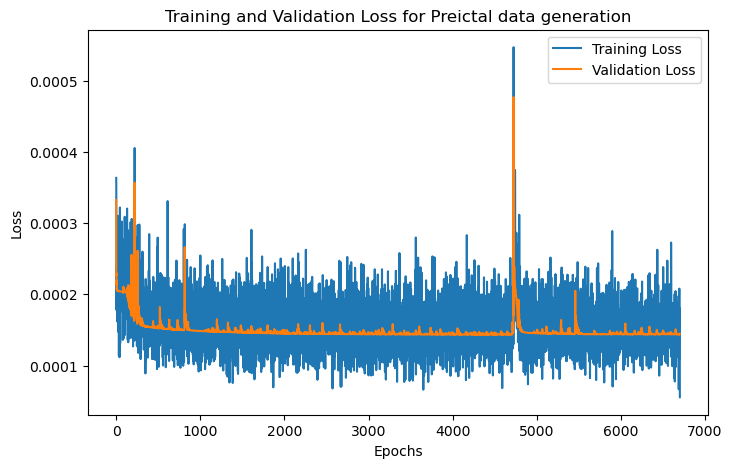

In [62]:
import matplotlib.pyplot as plt

# train_losses_preictal and val_losses_preictal contain the loss values across epochs
# Plotting training and validation loss
epochs = range(1, len(train_losses_preictal) + 1)

plt.figure(figsize=(8, 5))
plt.plot(epochs, train_losses_preictal, label='Training Loss')
plt.plot(epochs, val_losses_preictal, label='Validation Loss')
plt.title('Training and Validation Loss for Preictal data generation')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [64]:
# Generate synthetic data samples
num_samples_to_generate = 2714
with torch.no_grad():
    generated_samples_preictal = []
    for _ in range(num_samples_to_generate):
        noise = torch.randn(1, X_pre.shape[1], 32)  # Generate noise with 32 channels
        generated = model_preictal.decoder(noise.permute(0, 2, 1)).squeeze().numpy()  # Adjust input shape for the decoder
        generated_samples_preictal.append(generated)

# Convert generated samples to a NumPy array
generated_samples_preictal = np.array(generated_samples_preictal)

In [65]:
generated_samples_preictal.shape

(2714, 16, 4000)

In [66]:
np.save('generated_samples_preictal', generated_samples_preictal)

In [63]:
np.save('X_train_samples_preictal', X_pre_train)
np.save('y_train_samples_preictal', y_pre_train)
np.save('X_val_samples_preictal', X_pre_val)
np.save('y_val_samples_preictal', y_pre_val)